<a href="https://colab.research.google.com/github/simplething4057/Final-Team7/blob/main/%ED%8C%8C%EC%9D%B4%EB%84%90_%EA%B9%80%EC%84%B1%EC%9D%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd

df = pd.read_csv('/content/dairy_dataset.csv')

In [96]:
df['Date']= pd.to_datetime(df['Date'])
df['Production Date'] = pd.to_datetime(df['Production Date'])
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])

In [97]:
# 평균 유통기한
avg_Shelf_life = df.groupby('Product Name')['Shelf Life (days)'].mean().reset_index()
avg_Shelf_life

,Product Name,Shelf Life (days)
0,Butter,32.932715
1,Buttermilk,10.572414
2,Cheese,57.324190
3,Curd,6.025052
4,Ghee,105.741294
5,Ice Cream,25.458629
6,Lassi,14.847875
7,Milk,12.923077
8,Paneer,10.662132
9,Yogurt,25.517162


In [98]:
df.columns = df.columns.str.replace('(liters/kg)', '', regex=False)
df.columns = df.columns.str.replace('(days)', '', regex=False)
df.columns = df.columns.str.replace('(acres)', '', regex=False)
df.columns = df.columns.str.replace('(sold)', 'Sold', regex=False)
df.columns = df.columns.str.replace('(INR)', '', regex=False)
df.columns = df.columns.str.replace('.', '', regex=False)
df.columns = df.columns.str.rstrip()
df = df.rename(columns=lambda x: x.replace(' ', '_'))

In [99]:
import numpy as np
import pandas as pd

df['Sales_Period_Days'] = (df['Date'] - df['Production_Date']).dt.days
df["Avg_Daily_Sales"] = df["Quantity_Sold"] / (df["Date"] - df["Production_Date"]).dt.days
df['Remaining_Shelf_Life'] = (df['Expiration_Date'] - df['Date']).dt.days

df['Expected_Waste_Qty'] = np.where(
    df['Remaining_Shelf_Life'] <= 0,
    df['Quantity_in_Stock'],
    (df['Quantity_in_Stock'] - (df['Avg_Daily_Sales'] * df['Remaining_Shelf_Life'])).clip(lower=0)
)

df['Expected_Waste_Qty'] = df['Expected_Waste_Qty'].fillna(df['Quantity_in_Stock'])
df['Waste_Rate'] = df['Expected_Waste_Qty'] / df['Quantity']

In [100]:
df.drop('Farm_Size', axis=1, inplace=True)

In [109]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

In [102]:
df.columns

Index(['Location', 'Total_Land_Area', 'Number_of_Cows', 'Date', 'Product_ID',
       'Product_Name', 'Brand', 'Quantity', 'Price_per_Unit', 'Total_Value',
       'Shelf_Life', 'Storage_Condition', 'Production_Date', 'Expiration_Date',
       'Quantity_Sold', 'Price_per_Unit_Sold', 'Approx_Total_Revenue',
       'Customer_Location', 'Sales_Channel', 'Quantity_in_Stock',
       'Minimum_Stock_Threshold', 'Reorder_Quantity', 'Sales_Period_Days',
       'Avg_Daily_Sales', 'Remaining_Shelf_Life', 'Expected_Waste_Qty',
       'Waste_Rate'],
      dtype='object')

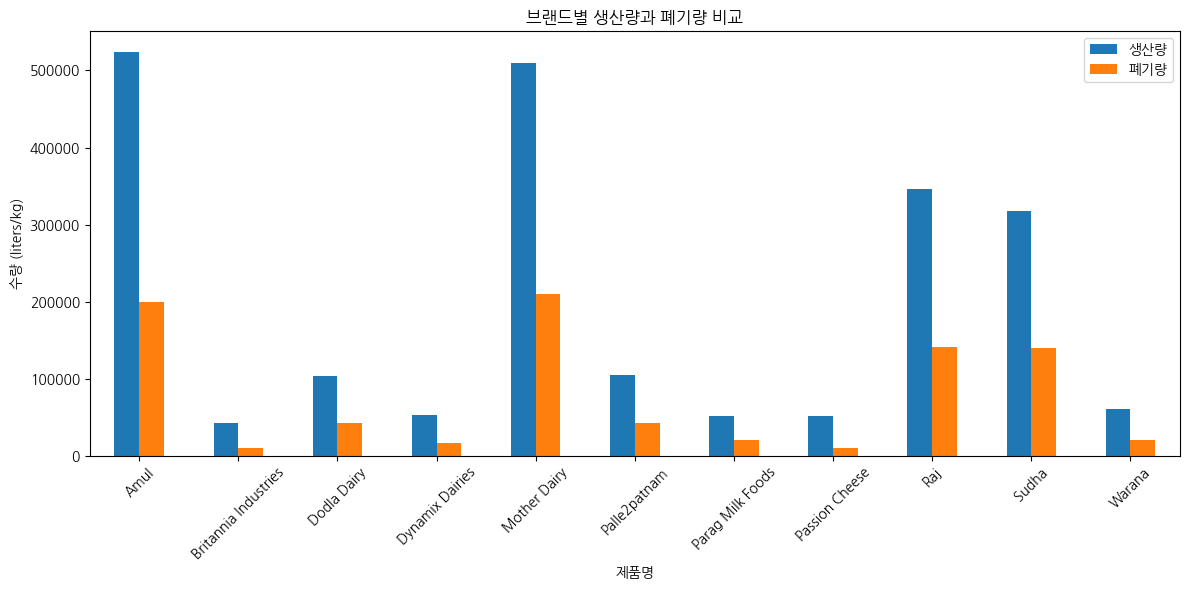

In [45]:
# 생산량(Quantity)과 폐기량(Expected_Waste_Qty) 비교
prod_vs_EXQ = df.groupby("Brand")[["Quantity", "Expected_Waste_Qty"]].sum()

# 바그래프 출력
prod_vs_EXQ.plot(kind="bar", figsize=(12,6))
plt.title("브랜드별 생산량과 폐기량 비교")
plt.ylabel("수량 (liters/kg)")
plt.xlabel("제품명")
plt.xticks(rotation=45)
plt.legend(["생산량", "폐기량"])
plt.tight_layout()
plt.show()

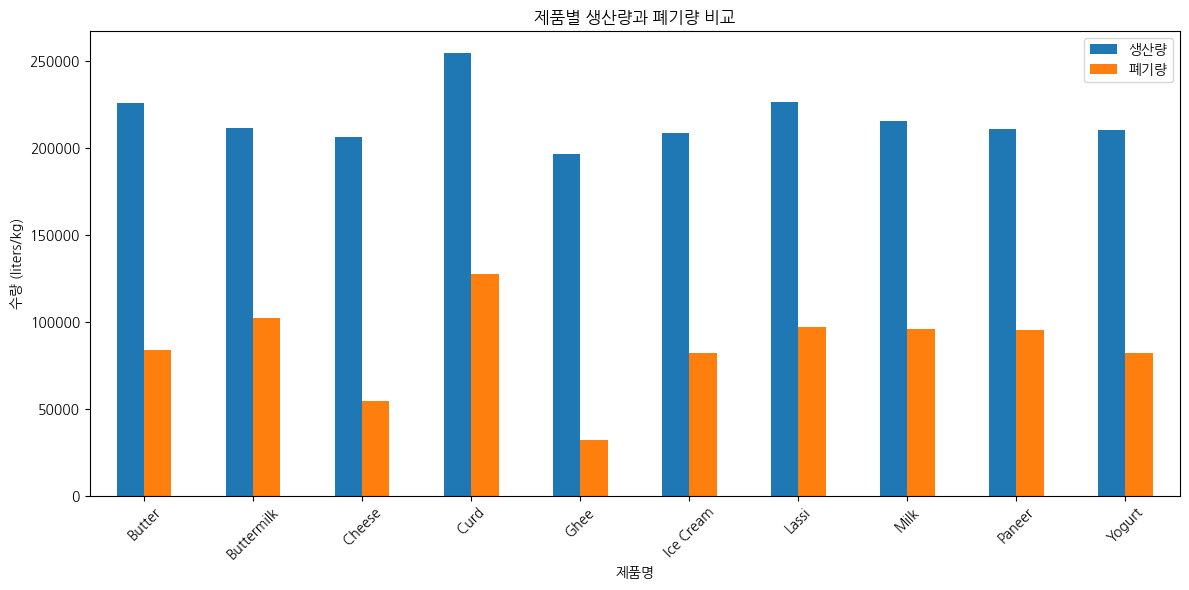

In [46]:
# 생산량(Quantity)과 폐기량(Expected_Waste_Qty) 비교
prod_Nvs_EWQ = df.groupby("Product_Name")[["Quantity", "Expected_Waste_Qty"]].sum()

# 바그래프 출력
prod_Nvs_EWQ.plot(kind="bar", figsize=(12,6))
plt.title("제품별 생산량과 폐기량 비교")
plt.ylabel("수량 (liters/kg)")
plt.xlabel("제품명")
plt.xticks(rotation=45)
plt.legend(["생산량", "폐기량"])
plt.tight_layout()
plt.show()

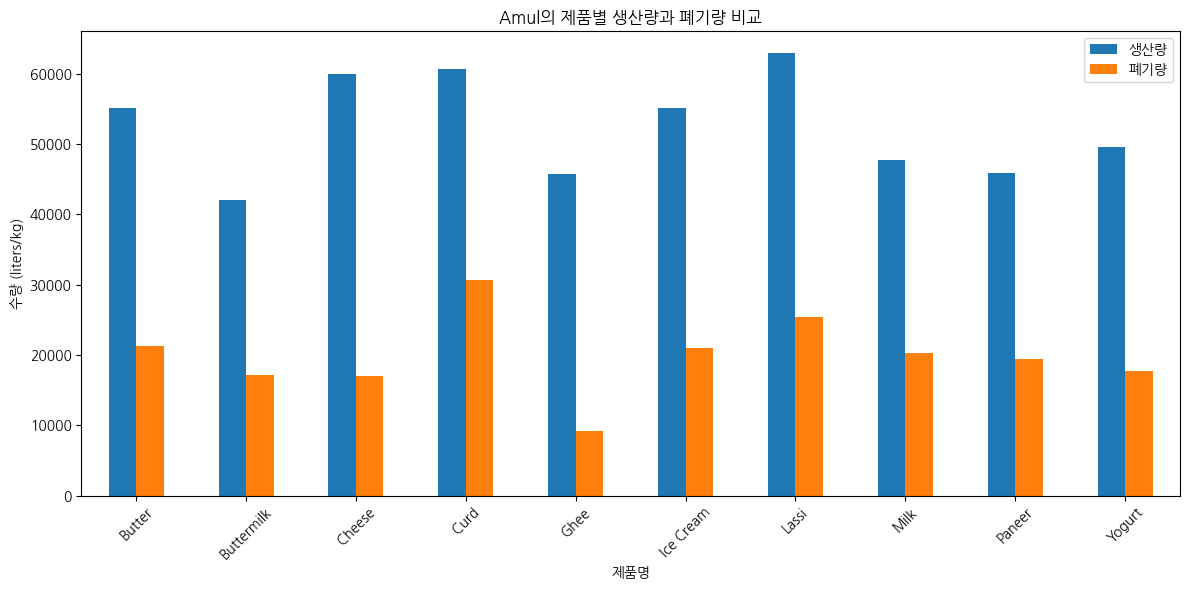

In [47]:
# 특정 브랜드별 생산량 vs 폐기량 비교
B_Q_EWQ = df[df["Brand"] == "Amul"].groupby("Product_Name")[["Quantity", "Expected_Waste_Qty"]].sum()

B_Q_EWQ.plot(kind="bar", figsize=(12,6))
plt.title("Amul의 제품별 생산량과 폐기량 비교")
plt.ylabel("수량 (liters/kg)")
plt.xlabel("제품명")
plt.xticks(rotation=45)
plt.legend(["생산량", "폐기량"])
plt.tight_layout()
plt.show()

In [103]:
df["Shelf_Life_Days"] = (df["Expiration_Date"] - df["Production_Date"]).dt.days

In [104]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Q("Waste_Rate") ~ C(Brand)', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)

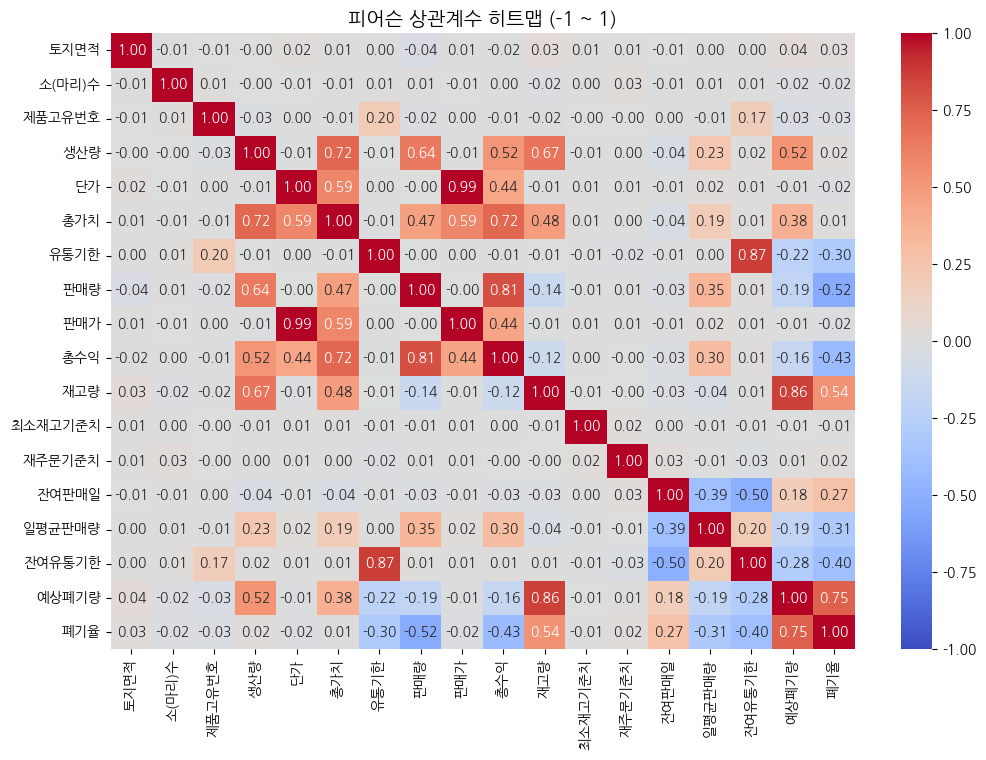

In [43]:
mapping = {"Frozen": 0, "Tetra Pack": 1, "Refrigerated": 2, "Polythene Packet" : 3, "Ambient" : 4}

# 수치형 데이터만 선택
numeric_df = df.select_dtypes(include=[np.number])

plt.rcParams['font.family'] = 'NanumGothic'   # 없으면 'AppleGothic', 'Malgun Gothic' 등으로 바꿔보세요
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 깨짐 방지

name_map = {
    'Location': '농장위치',
    'Total_Land_Area': '토지면적',
    'Number_of_Cows': '소(마리)수',
    'Date': '기록일자',
    'Customer_Location' : '고객위치',
    'Sales_Channel': '판매채널',
    'Product_ID': '제품고유번호',
    'Product_Name': '제품명',
    'Brand': '브랜드',
    'Quantity': '생산량',
    'Total_Value' : '총가치',
    'Quantity_Sold': '판매량',
    'Price_per_Unit_Sold': '판매가',
    'Quantity_in_Stock': '재고량',
    'Price_per_Unit': '단가',
    'Approx_Total_Revenue': '총수익',
    'Minimum_Stock_Threshold': '최소재고기준치',
    'Reorder_Quantity': '재주문기준치',
    'Shelf_Life': '유통기한',
    'Shelf_Life_Days': '유통기한(일)',
    'Waste_Rate': '폐기율',
    'Prod_per_Acre': '면적당생산',
    'Sales_Period_Days': '판매기간(일)',
    'Avg_Daily_Sales': '일평균판매량',
    'Remaining_Shelf_Life': '잔여유통기한',
    'Sales_Period_Days': '잔여판매일',
    'Expected_Waste_Qty': '예상폐기량'
}

# 피어슨 상관계수 계산
corr = numeric_df.corr(method="pearson").rename(index=name_map, columns=name_map)

# 히트맵 시각화 (-1 ~ 1 고정)
plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    vmin=-1, vmax=1   # 색상 범위를 -1~1로 고정
)

plt.title("피어슨 상관계수 히트맵 (-1 ~ 1)", fontsize=14)
plt.show()

In [50]:
anova_table

,sum_sq,df,F,PR(>F)
C(Brand),7.359310,10.0,7.043036,4.581461e-11
Residual,450.772401,4314.0,NaN,NaN


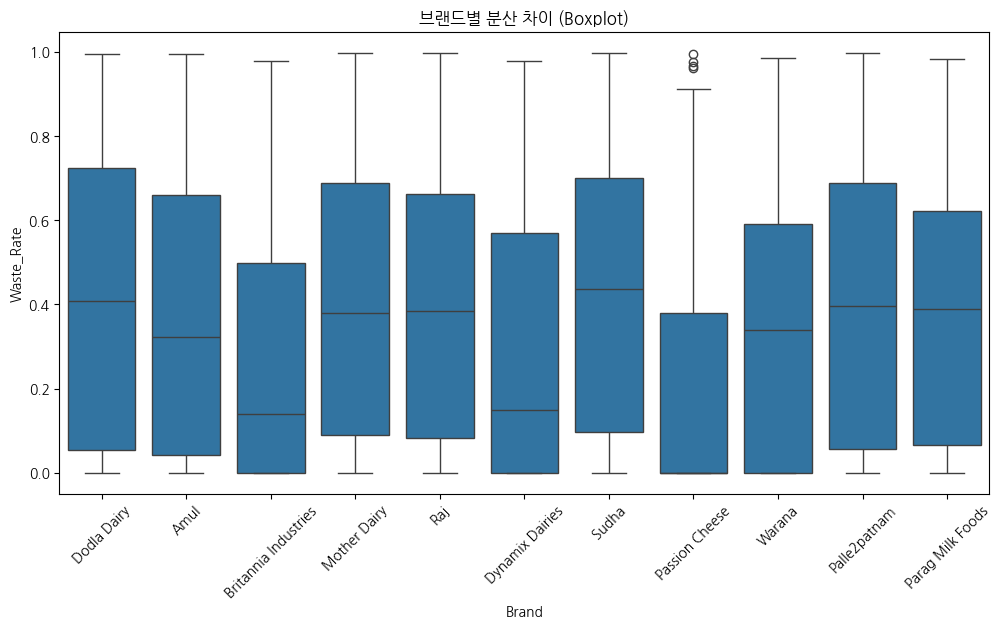

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x="Brand", y="Waste_Rate", data=df)  # Target_Variable은 분석한 변수명으로 교체
plt.xticks(rotation=45)
plt.title("브랜드별 분산 차이 (Boxplot)")
plt.show()

독립: Brand
오차항(Residual)   

F = 7.043036   
집단 간 변동이 집단 내 변동보다 7배 큼, p = 4.581461e-11 으로 p <=0.05 브랜드 별 평균 차이는 유의하다라고 할 수 있다.

In [52]:
# 브랜드별 제품군 groupby
df_grouped = df.groupby(["Brand","Product_Name"], as_index=False)["Waste_Rate"].mean()

model01 = ols("Waste_Rate ~ C(Brand) + C(Product_Name)", data=df_grouped).fit()
anova_table01 = sm.stats.anova_lm(model01, typ=2)
anova_table01

,sum_sq,df,F,PR(>F)
C(Brand),0.010759,10.0,0.740950,6.797036e-01
C(Product_Name),0.325593,9.0,24.913235,5.663284e-09
Residual,0.029042,20.0,NaN,NaN


In [53]:
df_grouped

,Brand,Product_Name,Waste_Rate
0,Amul,Butter,0.393872
1,Amul,Buttermilk,0.409908
2,Amul,Cheese,0.271931
3,Amul,Curd,0.484192
4,Amul,Ghee,0.187043
5,Amul,Ice Cream,0.419245
6,Amul,Lassi,0.410161
7,Amul,Milk,0.408790
8,Amul,Paneer,0.423558
9,Amul,Yogurt,0.348393


In [54]:
df.columns

Index(['Location', 'Total_Land_Area', 'Number_of_Cows', 'Date', 'Product_ID',
       'Product_Name', 'Brand', 'Quantity', 'Price_per_Unit', 'Total_Value',
       'Shelf_Life', 'Storage_Condition', 'Production_Date', 'Expiration_Date',
       'Quantity_Sold', 'Price_per_Unit_Sold', 'Approx_Total_Revenue',
       'Customer_Location', 'Sales_Channel', 'Quantity_in_Stock',
       'Minimum_Stock_Threshold', 'Reorder_Quantity', 'Sales_Period_Days',
       'Avg_Daily_Sales', 'Remaining_Shelf_Life', 'Expected_Waste_Qty',
       'Waste_Rate', 'Shelf_Life_Days'],
      dtype='object')

In [55]:
df_grouped02 = df.groupby(["Brand","Product_Name", "Shelf_Life_Days"], as_index=False)["Waste_Rate"].mean()

# 상호작(x) 가정
model02 = ols("Waste_Rate ~ C(Brand) + C(Product_Name) + (Shelf_Life_Days)", data=df_grouped02).fit()
anova_table02 = sm.stats.anova_lm(model02, typ=2)
anova_table02

,sum_sq,df,F,PR(>F)
C(Brand),0.424379,10.0,1.046166,4.024435e-01
C(Product_Name),0.352260,9.0,0.964866,4.679209e-01
Shelf_Life_Days,1.089695,1.0,26.862791,2.839013e-07
Residual,29.247520,721.0,NaN,NaN


In [56]:
df_grouped02 = df.groupby(["Brand","Product_Name", "Shelf_Life_Days"], as_index=False)["Waste_Rate"].mean()

# 상호작용 포함(브랜드와 제품군) + 유통기한의 공변량 효과
model03 = ols("Waste_Rate ~ C(Brand) * C(Product_Name) + (Shelf_Life_Days)", data=df_grouped02).fit()
anova_table03 = sm.stats.anova_lm(model03, typ=3)
anova_table03

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 90, but rank is 27
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,3.093375,1.0,75.425554,2.653574e-17
C(Brand),0.184975,10.0,0.451024,9.207771e-01
C(Product_Name),0.133268,9.0,0.361050,9.531770e-01
C(Brand):C(Product_Name),2.784775,90.0,0.754455,8.119734e-01
Shelf_Life_Days,1.081209,1.0,26.363048,3.669054e-07
Residual,28.749617,701.0,NaN,NaN


In [57]:
# 유통기한의 상호작용도 포함
model04 = ols("Waste_Rate ~ C(Brand) * C(Product_Name) * (Shelf_Life_Days)", data=df_grouped02).fit()
anova_table04 = sm.stats.anova_lm(model04, typ=3)
anova_table04

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 90, but rank is 27
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 90, but rank is 27
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,0.202809,1.0,4.763467,0.029421
C(Brand),0.210365,10.0,0.494093,0.894344
C(Product_Name),0.117361,9.0,0.306279,0.972878
C(Brand):C(Product_Name),1.272352,90.0,0.332048,0.999511
Shelf_Life_Days,0.055325,1.0,1.299450,0.254726
C(Brand):Shelf_Life_Days,0.157486,10.0,0.369895,0.959448
C(Product_Name):Shelf_Life_Days,0.240191,9.0,0.626832,0.774641
C(Brand):C(Product_Name):Shelf_Life_Days,0.886318,90.0,0.231304,0.999987
Residual,28.185272,662.0,NaN,NaN


[셀 크기]
                   Brand Storage_Condition   n
6        Passion Cheese            Frozen  40
3  Britannia Industries      Refrigerated  42
2  Britannia Industries            Frozen  46
4       Dynamix Dairies            Frozen  47
0                  Amul            Frozen  49
7        Passion Cheese      Refrigerated  56
5       Dynamix Dairies      Refrigerated  59
1                  Amul      Refrigerated  62

[이원 ANOVA]
                                   sum_sq     df         F    PR(>F)
C(Brand)                        0.475104    3.0  1.511639  0.210985
C(Storage_Condition)            0.149297    1.0  1.425059  0.233293
C(Brand):C(Storage_Condition)   0.305366    3.0  0.971583  0.406079
Residual                       41.172920  393.0       NaN       NaN

[효과크기]
                                  eta2  partial_eta2
C(Brand)                       0.0113        0.0114
C(Storage_Condition)           0.0035        0.0036
C(Brand):C(Storage_Condition)  0.0073        0.0074

[Tukey 

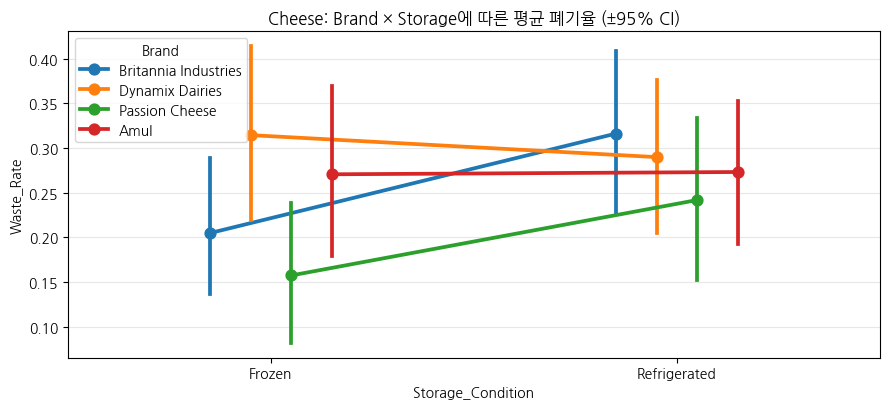

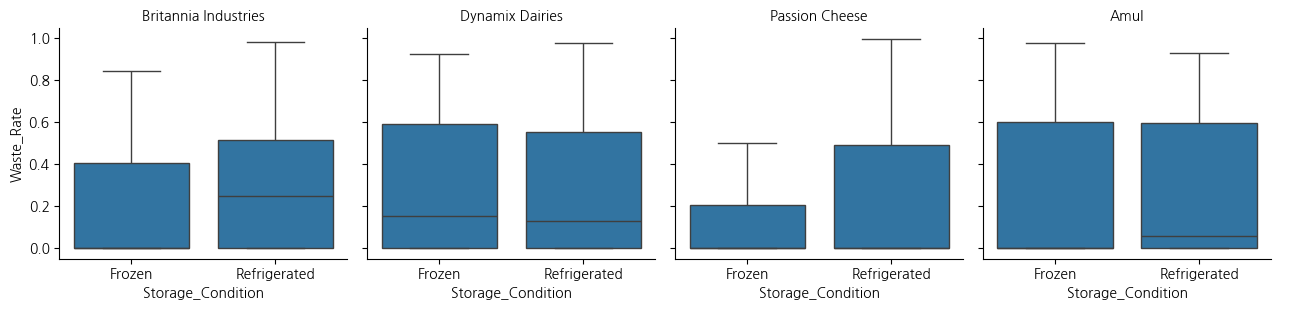

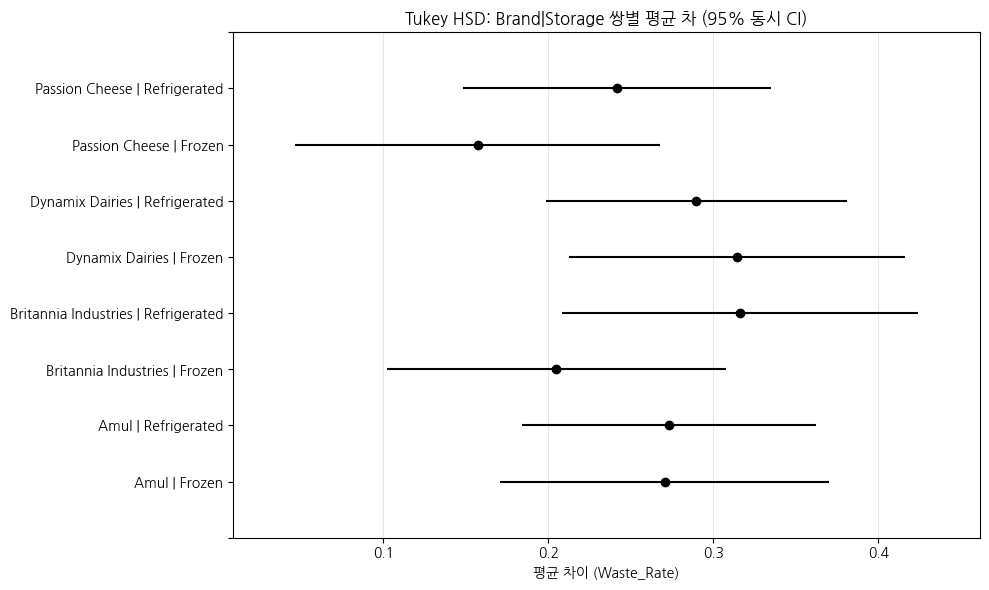

In [58]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 0) 치즈만 필터 + 결측 제거
cheese = (df
          .loc[df['Product_Name']=='Cheese', ['Waste_Rate','Brand','Storage_Condition']]
          .dropna())

# (선택) 셀 크기 확인: 각 Brand×Storage 조합 표본수
cell_sizes = (cheese
              .groupby(['Brand','Storage_Condition'])
              .size().rename('n').reset_index())
print("[셀 크기]\n", cell_sizes.sort_values('n'))

# 1) 이원 ANOVA (상호작용 포함)
m = smf.ols('Waste_Rate ~ C(Brand) * C(Storage_Condition)', data=cheese).fit()
aov = anova_lm(m, typ=2)  # Type II ANOVA
print("\n[이원 ANOVA]\n", aov)

# (참고) 효과크기 η² / partial η²
ss_total = aov['sum_sq'].sum()
ss_resid = aov.loc['Residual','sum_sq']
eff = aov.drop(index='Residual').copy()
eff['eta2'] = eff['sum_sq'] / ss_total
eff['partial_eta2'] = eff['sum_sq'] / (eff['sum_sq'] + ss_resid)
print("\n[효과크기]\n", eff[['eta2','partial_eta2']].round(4))

# 2) 사후분석 (모든 Brand×Storage 조합 간 Tukey HSD)
cheese['group'] = cheese['Brand'].astype(str) + ' | ' + cheese['Storage_Condition'].astype(str)
tukey = pairwise_tukeyhsd(endog=cheese['Waste_Rate'], groups=cheese['group'], alpha=0.05)
print("\n[Tukey HSD 요약]\n", tukey.summary())

# --- 시각화 ---

# A) 상호작용 플롯: 브랜드 라인, x=보관방법, y=평균 폐기율(±95% CI)
plt.figure(figsize=(9,4.2))
sns.pointplot(
    data=cheese, x='Storage_Condition', y='Waste_Rate', hue='Brand',
    dodge=0.3, errorbar=('ci',95)
)
plt.title('Cheese: Brand × Storage에 따른 평균 폐기율 (±95% CI)')
plt.ylabel('Waste_Rate'); plt.xlabel('Storage_Condition')
plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

# B) 박스플롯(분포 확인): x=보관방법, col=브랜드
g = sns.catplot(
    data=cheese, kind='box', x='Storage_Condition', y='Waste_Rate',
    col='Brand', col_wrap=4, sharey=True, height=3.2, showfliers=False
)
g.set_titles('{col_name}'); g.set_xlabels('Storage_Condition'); g.set_ylabels('Waste_Rate')
plt.tight_layout(); plt.show()

# C) Tukey 동시신뢰구간 플롯 (쌍별 평균차)
fig = tukey.plot_simultaneous(figsize=(10,6))
plt.title('Tukey HSD: Brand|Storage 쌍별 평균 차 (95% 동시 CI)')
plt.xlabel('평균 차이 (Waste_Rate)'); plt.grid(axis='x', alpha=0.3)
plt.tight_layout(); plt.show()


In [59]:
# 브랜드별 제품군 groupby
df_grouped = df.groupby(["Product_Name", "Shelf_Life_Days"], as_index=False)["Waste_Rate"].mean()

model01 = ols("Waste_Rate ~ C(Product_Name) + C(Shelf_Life_Days)", data=df_grouped).fit()
anova_table01 = sm.stats.anova_lm(model01, typ=2)
anova_table01

,sum_sq,df,F,PR(>F)
C(Product_Name),0.012199,9.0,0.108668,0.999401
C(Shelf_Life_Days),3.066674,145.0,1.695606,0.005548
Residual,0.960429,77.0,NaN,NaN


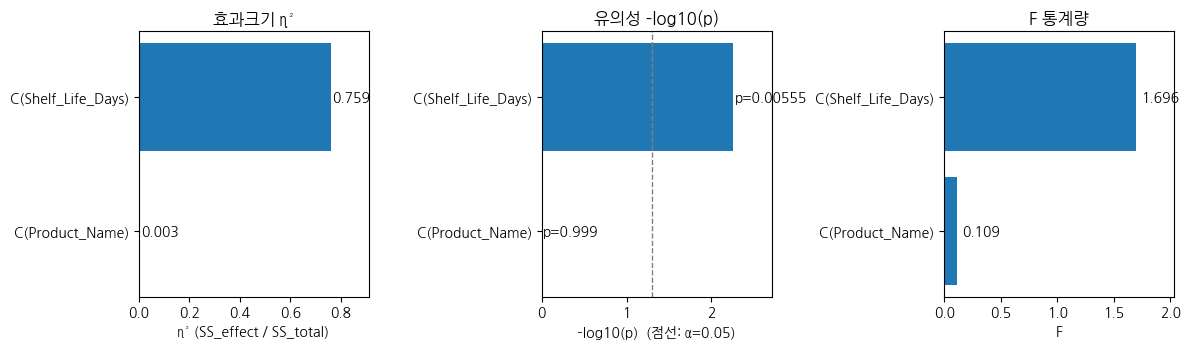

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1) ANOVA 결과를 DataFrame으로 구성 (질문에서 준 값) ===
aov = pd.DataFrame({
    "term": ["C(Product_Name)", "C(Shelf_Life_Days)", "Residual"],
    "sum_sq": [0.012199, 3.066674, 0.960429],
    "df":     [9.0,        145.0,      77.0],
    "F":      [0.108668,   1.695606,   np.nan],
    "p":      [0.999401,   0.005548,   np.nan],   # PR(>F)
})

# === 2) 효과크기(eta^2, partial eta^2) 계산 ===
ss_total = aov["sum_sq"].sum()
ss_resid = aov.loc[aov["term"]=="Residual", "sum_sq"].values[0]

effects = aov[aov["term"]!="Residual"].copy()
effects["eta2"] = effects["sum_sq"] / ss_total
effects["partial_eta2"] = effects["sum_sq"] / (effects["sum_sq"] + ss_resid)

# === 3) –log10(p) 계산 (Residual 제외) ===
effects["neglog10_p"] = -np.log10(effects["p"])

# === 4) 시각화 ===
plt.figure(figsize=(12,3.6))

# (A) 효과크기 eta^2
plt.subplot(1,3,1)
plt.barh(effects["term"], effects["eta2"])
plt.title("효과크기 η²")
plt.xlabel("η² (SS_effect / SS_total)")
for y, v in enumerate(effects["eta2"]):
    plt.text(v + 0.005, y, f"{v:.3f}", va="center")
plt.xlim(0, max(0.05, effects["eta2"].max()*1.2))

# (B) 유의성: –log10(p) (α=0.05 선)
plt.subplot(1,3,2)
plt.barh(effects["term"], effects["neglog10_p"])
alpha = 0.05
thr = -np.log10(alpha)     # ≈ 1.301
plt.axvline(thr, ls="--", lw=1, color="gray")
plt.title("유의성 –log10(p)")
plt.xlabel("–log10(p)  (점선: α=0.05)")
for y, v in enumerate(effects["neglog10_p"]):
    plt.text(v + 0.02, y, f"p={effects['p'].iloc[y]:.3g}", va="center")
plt.xlim(0, max(thr*1.3, effects["neglog10_p"].max()*1.2))

# (C) F-statistics
plt.subplot(1,3,3)
plt.barh(effects["term"], effects["F"])
plt.title("F 통계량")
plt.xlabel("F")
for y, v in enumerate(effects["F"]):
    plt.text(v + 0.05, y, f"{v:.3f}", va="center")
plt.xlim(0, max(2.0, effects["F"].max()*1.2))

plt.tight_layout()
plt.show()

              sum_sq      df         F        PR(>F)
C(Brand)    7.359310    10.0  7.043036  4.581461e-11
Residual  450.772401  4314.0       NaN           NaN


/tmp/ipython-input-3147556578.py:22: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=summary, x='Brand', y='mean', join=False, errorbar=None)


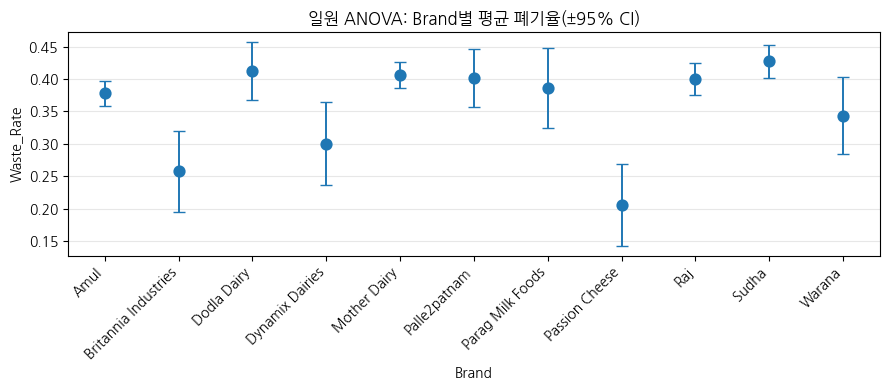

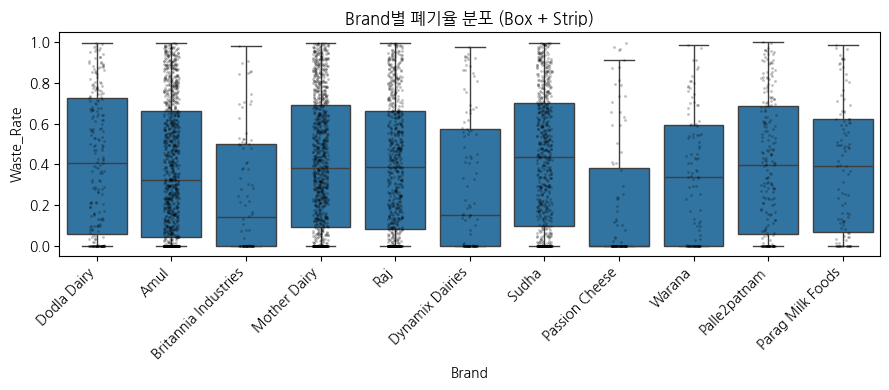

In [61]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 일원 ANOVA: Waste_Rate ~ C(Brand)
m1 = smf.ols('Waste_Rate ~ C(Brand)', data=df).fit()
anova1 = sm.stats.anova_lm(m1, typ=2)
print(anova1)

# 집단별 평균/표준오차/95% CI
g = df.groupby('Brand')['Waste_Rate']
summary = pd.DataFrame({
    'mean': g.mean(),
    'se': g.std(ddof=1)/np.sqrt(g.count()),
    'n': g.count()
})
summary['ci95'] = 1.96 * summary['se']
summary = summary.reset_index()

# 시각화: 평균±CI (막대 or 포인트)
plt.figure(figsize=(9,4))
sns.pointplot(data=summary, x='Brand', y='mean', join=False, errorbar=None)
plt.errorbar(x=np.arange(len(summary)), y=summary['mean'],
             yerr=summary['ci95'], fmt='none', capsize=4, lw=1.4, color='C0')
plt.title('일원 ANOVA: Brand별 평균 폐기율(±95% CI)')
plt.ylabel('Waste_Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

# 분포도 함께: 상자그림/바이올린
plt.figure(figsize=(9,4))
sns.boxplot(data=df, x='Brand', y='Waste_Rate', showfliers=False)
sns.stripplot(data=df, x='Brand', y='Waste_Rate', color='k', alpha=0.25, size=2)
plt.title('Brand별 폐기율 분포 (Box + Strip)'); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

/tmp/ipython-input-1099386976.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=summary, y='Brand', x='mean', join=False, errorbar=None, orient='h')


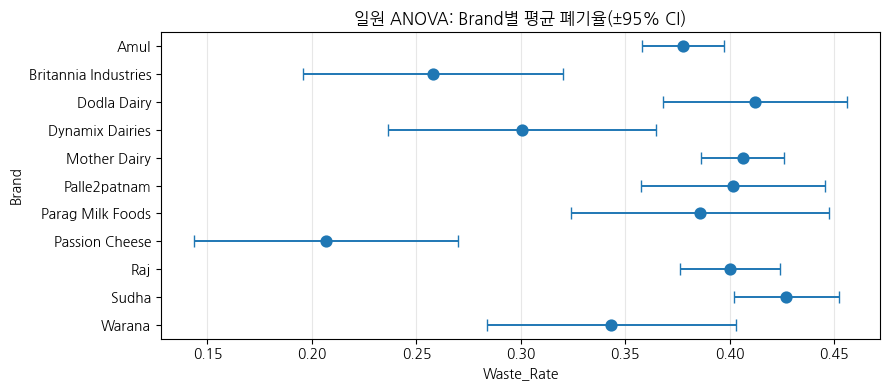

In [62]:
plt.figure(figsize=(9,4))
sns.pointplot(data=summary, y='Brand', x='mean', join=False, errorbar=None, orient='h')
# 에러바도 가로로
plt.errorbar(y=np.arange(len(summary)), x=summary['mean'],
             xerr=summary['ci95'], fmt='none', capsize=4, lw=1.4, color='C0')
plt.title('일원 ANOVA: Brand별 평균 폐기율(±95% CI)')
plt.xlabel('Waste_Rate')
plt.ylabel('Brand')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout(); plt.show()

In [63]:
import scipy.stats as st

res = m2.resid
fit = m2.fittedvalues

# Residuals vs Fitted
plt.figure(figsize=(5.2,4))
plt.scatter(fit, res, s=10, alpha=0.6)
plt.axhline(0, color='r', ls='--')
plt.title('Residuals vs Fitted'); plt.xlabel('Fitted'); plt.ylabel('Residuals')
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# QQ plot
sm.graphics.qqplot(res, dist=st.norm, line='45', fit=True)
plt.title('QQ Plot (잔차 정규성)'); plt.tight_layout(); plt.show()


NameError: name 'm2' is not defined

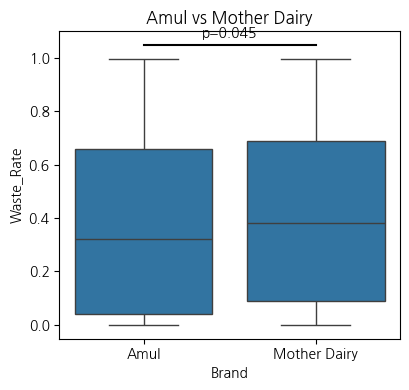

In [64]:
from scipy.stats import ttest_ind

# 예시: 특정 두 집단(A,B)의 차이 p값을 박스플롯에 표기
A, B = 'Amul', 'Mother Dairy'
yA = df.loc[df['Brand']==A, 'Waste_Rate'].dropna()
yB = df.loc[df['Brand']==B, 'Waste_Rate'].dropna()
_, p = ttest_ind(yA, yB, equal_var=False)

plt.figure(figsize=(4.2,4))
sns.boxplot(data=df[df['Brand'].isin([A,B])], x='Brand', y='Waste_Rate', showfliers=False)
# 주석
ymax = df.loc[df['Brand'].isin([A,B]), 'Waste_Rate'].max()
plt.plot([0,1], [ymax*1.05, ymax*1.05], color='k')
plt.text(0.5, ymax*1.08, f'p={p:.3g}', ha='center')
plt.title(f'{A} vs {B}'); plt.tight_layout(); plt.show()


In [65]:
# 브랜드별 제품군 groupby
df_grouped = df.groupby(["Product_Name", "Shelf_Life_Days"], as_index=False)["Waste_Rate"].mean()

model01 = ols("Waste_Rate ~ C(Product_Name) + (Shelf_Life_Days)", data=df_grouped).fit()
anova_table01 = sm.stats.anova_lm(model01, typ=2)
anova_table01

,sum_sq,df,F,PR(>F)
C(Product_Name),0.120420,9.0,0.832146,5.871696e-01
Shelf_Life_Days,0.417660,1.0,25.975719,7.438927e-07
Residual,3.537348,220.0,NaN,NaN


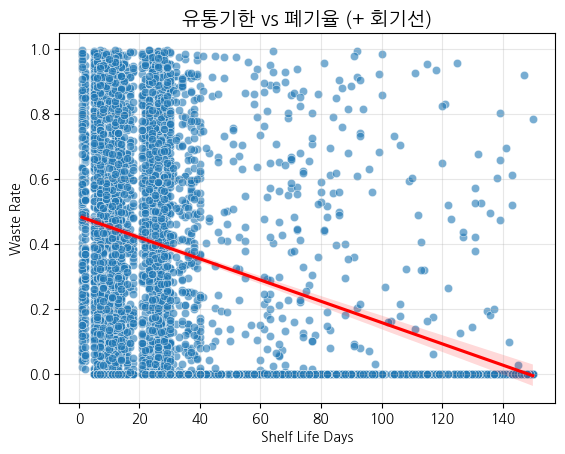

In [66]:
# 산점도
sns.scatterplot(data=df, x="Shelf_Life_Days", y="Waste_Rate", alpha=0.6)

# 선형 회귀선 (95% 신뢰구간 포함)
sns.regplot(data=df, x="Shelf_Life_Days", y="Waste_Rate", scatter=False, ci=95, color="red")

plt.title("유통기한 vs 폐기율 (+ 회기선)", fontsize=14)
plt.xlabel("Shelf Life Days")
plt.ylabel("Waste Rate")
plt.grid(alpha=0.3)
plt.show()

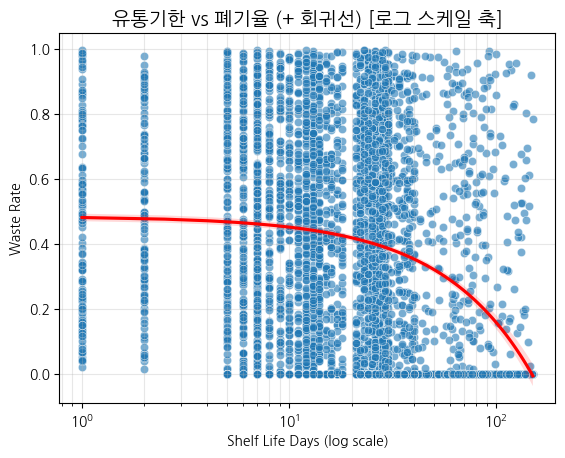

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="Shelf_Life_Days", y="Waste_Rate", alpha=0.6)
sns.regplot(data=df, x="Shelf_Life_Days", y="Waste_Rate", scatter=False, ci=95, color="red")

plt.xscale('log')   # x 로그
# plt.yscale('log') # y도 로그로 보고 싶으면 주석 해제
plt.title("유통기한 vs 폐기율 (+ 회귀선) [로그 스케일 축]", fontsize=14)
plt.xlabel("Shelf Life Days (log scale)")
plt.ylabel("Waste Rate")
plt.grid(alpha=0.3, which='both')
plt.show()

In [68]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf

# 1) 전체: Spearman (비선형/단조 검출)
rho, p = stats.spearmanr(df['Shelf_Life_Days'], df['Waste_Rate'], nan_policy='omit')
print("Spearman ρ (전체):", rho, "p:", p)

# 2) 집단별: 보관조건/제품별 Spearman
grp = (df
       .dropna(subset=['Shelf_Life_Days','Waste_Rate'])
       .groupby(['Product_Name','Storage_Condition']))
res = grp.apply(lambda g: stats.spearmanr(g['Shelf_Life_Days'], g['Waste_Rate']).correlation) \
         .rename('spearman_rho').reset_index()
print(res.sort_values('spearman_rho'))

# 3) 로그-선형 회귀: y ~ log(x)
df2 = df.dropna(subset=['Shelf_Life_Days','Waste_Rate']).copy()
df2['log_shelf'] = np.log1p(df2['Shelf_Life_Days'])
m1 = smf.ols('Waste_Rate ~ log_shelf', data=df2).fit()
print(m1.summary())

# 4) 구간(피스와이즈) 회귀: 임계점(예: 30일) 전/후 기울기 비교
cut = 30
df2['post'] = (df2['Shelf_Life_Days'] > cut).astype(int)
df2['slope_post'] = df2['post'] * (df2['Shelf_Life_Days'] - cut)
m2 = smf.ols('Waste_Rate ~ Shelf_Life_Days + post + slope_post', data=df2).fit()
print(m2.summary())

Spearman ρ (전체): -0.31576808790942634 p: 9.591864672667286e-101
   Product_Name Storage_Condition  spearman_rho
3        Cheese            Frozen     -0.316145
0        Butter            Frozen     -0.233436
4        Cheese      Refrigerated     -0.203923
6          Ghee           Ambient     -0.203405
11       Paneer      Refrigerated     -0.089718
7     Ice Cream            Frozen     -0.058149
5          Curd      Refrigerated     -0.050292
2    Buttermilk      Refrigerated     -0.027226
13       Yogurt      Refrigerated     -0.025287
1        Butter      Refrigerated     -0.021569
12       Yogurt            Frozen     -0.002256
10         Milk        Tetra Pack     -0.001484
8         Lassi      Refrigerated      0.022866
9          Milk  Polythene Packet      0.058809
                            OLS Regression Results                            
Dep. Variable:             Waste_Rate   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:   

/tmp/ipython-input-3666219068.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = grp.apply(lambda g: stats.spearmanr(g['Shelf_Life_Days'], g['Waste_Rate']).correlation) \


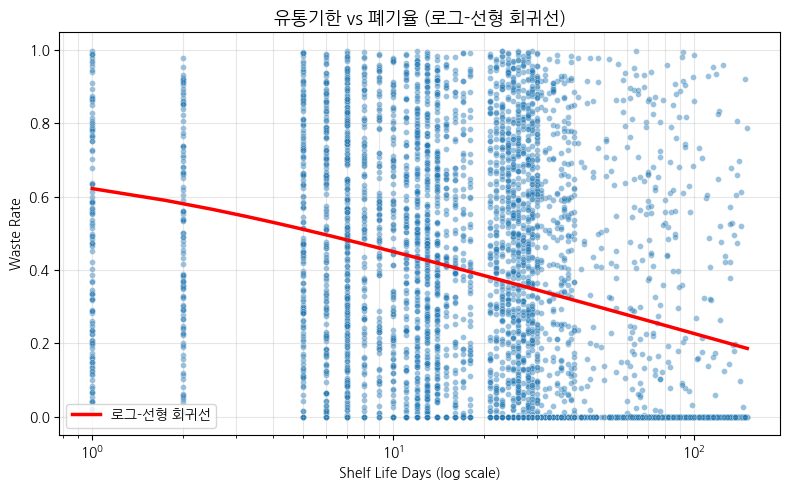

In [69]:
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
import statsmodels.formula.api as smf

df1 = df.dropna(subset=['Shelf_Life_Days','Waste_Rate']).copy()
df1['log_shelf'] = np.log1p(df1['Shelf_Life_Days'])

# 회귀 적합
m_log = smf.ols('Waste_Rate ~ log_shelf', data=df1).fit()

# 예측선용 그리드
xg = np.linspace(df1['Shelf_Life_Days'].min(), df1['Shelf_Life_Days'].max(), 200)
pred = m_log.predict(pd.DataFrame({'log_shelf': np.log1p(xg)}))

# 그림
plt.figure(figsize=(8,5))
sns.scatterplot(data=df1, x='Shelf_Life_Days', y='Waste_Rate', alpha=0.45, s=18)
plt.plot(xg, pred, color='red', linewidth=2.5, label='로그-선형 회귀선')

plt.xscale('log')
plt.title('유통기한 vs 폐기율 (로그-선형 회귀선)', fontsize=13)
plt.xlabel('Shelf Life Days (log scale)')
plt.ylabel('Waste Rate')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout(); plt.show()

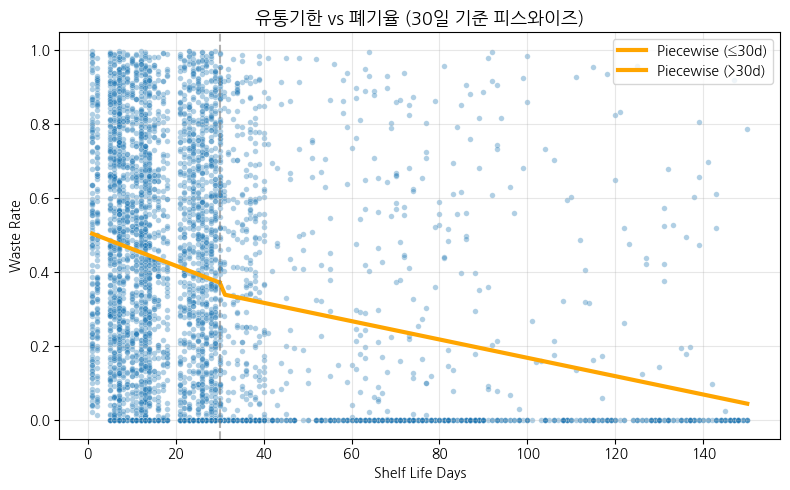

In [70]:
cut = 30
d = df1.copy()
d['post'] = (d['Shelf_Life_Days'] > cut).astype(int)
d['slope_post'] = d['post'] * (d['Shelf_Life_Days'] - cut)

m_pw = smf.ols('Waste_Rate ~ Shelf_Life_Days + post + slope_post', data=d).fit()

# 구간별 직선 생성
x1 = np.linspace(d['Shelf_Life_Days'].min(), cut, 100)
x2 = np.linspace(cut, d['Shelf_Life_Days'].max(), 100)

def pred_pw(x):
    post = (x > cut).astype(int)
    slope_post = post * (x - cut)
    X = pd.DataFrame({'Shelf_Life_Days': x, 'post': post, 'slope_post': slope_post})
    return m_pw.predict(X)

plt.figure(figsize=(8,5))
sns.scatterplot(data=d, x='Shelf_Life_Days', y='Waste_Rate', alpha=0.35, s=16)
plt.plot(x1, pred_pw(x1), color='orange', lw=3, label='Piecewise (≤30d)')
plt.plot(x2, pred_pw(x2), color='orange', lw=3, label='Piecewise (>30d)')
plt.axvline(cut, ls='--', color='gray', alpha=0.6)

plt.title('유통기한 vs 폐기율 (30일 기준 피스와이즈)', fontsize=13)
plt.xlabel('Shelf Life Days'); plt.ylabel('Waste Rate')
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()


/tmp/ipython-input-3126546584.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = g.apply(lambda t: stats.spearmanr(t['Shelf_Life_Days'], t['Waste_Rate']).correlation) \


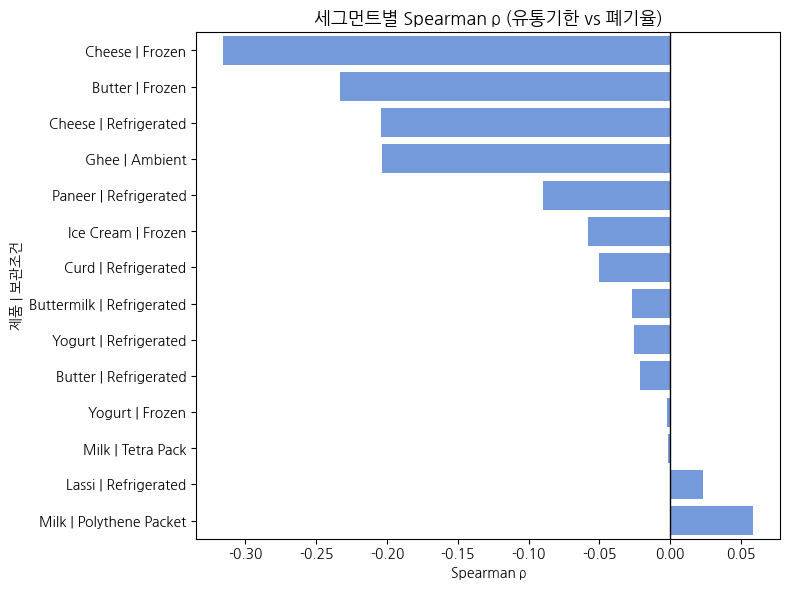

In [71]:
from scipy import stats

# 그룹별 Spearman ρ
g = (df.dropna(subset=['Shelf_Life_Days','Waste_Rate'])
       .groupby(['Product_Name','Storage_Condition']))
res = g.apply(lambda t: stats.spearmanr(t['Shelf_Life_Days'], t['Waste_Rate']).correlation) \
       .rename('spearman_rho').reset_index()

# 정렬 & 시각화
res['seg'] = res['Product_Name'].astype(str) + ' | ' + res['Storage_Condition'].astype(str)
res = res.sort_values('spearman_rho')

plt.figure(figsize=(8,6))
sns.barplot(data=res, y='seg', x='spearman_rho', orient='h', color='cornflowerblue')
plt.axvline(0, color='k', lw=1)
plt.title('세그먼트별 Spearman ρ (유통기한 vs 폐기율)', fontsize=13)
plt.xlabel('Spearman ρ'); plt.ylabel('제품 | 보관조건')
plt.tight_layout(); plt.show()


/tmp/ipython-input-644519645.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = g.apply(lambda t: stats.spearmanr(t['Shelf_Life_Days'], t['Waste_Rate']).correlation) \


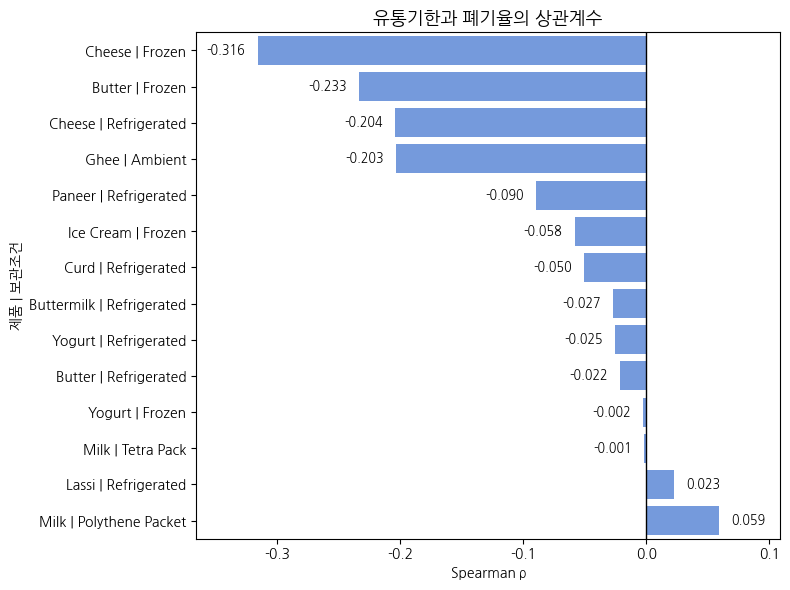

In [105]:
from scipy import stats

# 그룹별 Spearman ρ
g = (df.dropna(subset=['Shelf_Life_Days','Waste_Rate'])
       .groupby(['Product_Name','Storage_Condition']))
res = g.apply(lambda t: stats.spearmanr(t['Shelf_Life_Days'], t['Waste_Rate']).correlation) \
       .rename('spearman_rho').reset_index()

# 정렬 & 라벨용 문자열
res['seg'] = res['Product_Name'].astype(str) + ' | ' + res['Storage_Condition'].astype(str)
res = res.sort_values('spearman_rho').reset_index(drop=True)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=res, y='seg', x='spearman_rho', orient='h', color='cornflowerblue')
plt.axvline(0, color='k', lw=1)
plt.title('유통기한과 폐기율의 상관계수', fontsize=13) # 세그먼트별 Spearman ρ (유통기한 vs 폐기율)
plt.xlabel('Spearman ρ'); plt.ylabel('제품 | 보관조건')

# ── 값 주석 추가 ──
for p, v in zip(ax.patches, res['spearman_rho']):
    x = p.get_width()
    y = p.get_y() + p.get_height()/2
    # 값이 음수면 막대 왼쪽, 양수면 오른쪽에 살짝 띄움
    ha = 'right' if x < 0 else 'left'
    offset = -0.01 if x < 0 else 0.01
    ax.text(x + offset, y, f"{v:.3f}", va='center', ha=ha, fontsize=9)

# 값 표기를 위한 좌우 여백
xmin = min(0, res['spearman_rho'].min()) - 0.05
xmax = max(0, res['spearman_rho'].max()) + 0.05
ax.set_xlim(xmin, xmax)



plt.tight_layout(); plt.show()


/tmp/ipython-input-2705121808.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = g.apply(lambda t: stats.spearmanr(t['Shelf_Life_Days'], t['Waste_Rate']).correlation) \
/tmp/ipython-input-2705121808.py:52: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-2705121808.py:52: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-2705121808.py:52: UserWarning: Glyph 45257 (\N{HANGUL SYLLABLE NAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-2705121808.py:52: UserWarning: Glyph 46041 

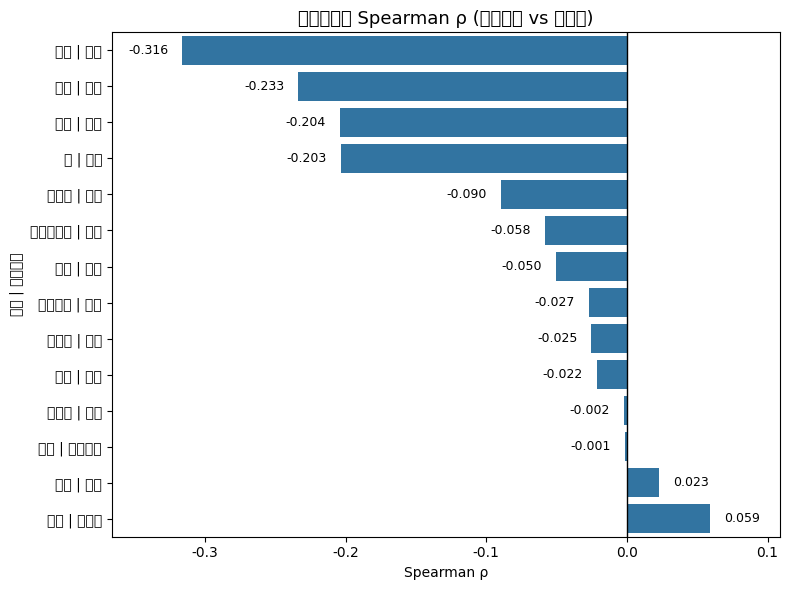

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1) 한글 폰트 (환경에 맞게 변경)
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows
# plt.rcParams['font.family'] = 'AppleGothic'   # macOS
# plt.rcParams['font.family'] = 'NanumGothic'   # Colab 등
plt.rcParams['axes.unicode_minus'] = False

# 2) 영→한 매핑
prod_map = {
    'Cheese':'치즈','Butter':'버터','Ghee':'기','Yogurt':'요거트','Curd':'커드',
    'Buttermilk':'버터밀크','Paneer':'파니르','Ice Cream':'아이스크림',
    'Lassi':'라씨','Milk':'우유'
}
stor_map = {
    'Refrigerated':'냉장','Frozen':'냉동','Ambient':'상온',
    'Polythene Packet':'폴리팩','Tetra Pack':'테트라팩'
}

# 3) 스피어만 계산
g = (df.dropna(subset=['Shelf_Life_Days','Waste_Rate'])
       .groupby(['Product_Name','Storage_Condition']))
res = g.apply(lambda t: stats.spearmanr(t['Shelf_Life_Days'], t['Waste_Rate']).correlation) \
       .rename('spearman_rho').reset_index()

# 4) y축 라벨을 한글로 생성
res['seg'] = res['Product_Name'].astype(str) + ' | ' + res['Storage_Condition'].astype(str)
res['seg_kor'] = res['Product_Name'].map(prod_map).fillna(res['Product_Name']).astype(str) \
                 + ' | ' + res['Storage_Condition'].map(stor_map).fillna(res['Storage_Condition']).astype(str)

# 5) 정렬 후 그리기 (y=seg_kor)
res = res.sort_values('spearman_rho').reset_index(drop=True)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=res, y='seg_kor', x='spearman_rho', orient='h')
plt.axvline(0, color='k', lw=1)
plt.title('세그먼트별 Spearman ρ (유통기한 vs 폐기율)', fontsize=13)
plt.xlabel('Spearman ρ')
plt.ylabel('제품 | 보관조건')   # y축 제목도 한글

# 막대 끝에 값 표시
for p, v in zip(ax.patches, res['spearman_rho']):
    x = p.get_width()
    y = p.get_y() + p.get_height()/2
    ha = 'right' if x < 0 else 'left'
    ax.text(x + ( -0.01 if x < 0 else 0.01 ), y, f"{v:.3f}", va='center', ha=ha, fontsize=9)

# 여백
ax.set_xlim(min(0, res['spearman_rho'].min())-0.05, max(0, res['spearman_rho'].max())+0.05)
plt.tight_layout(); plt.show()



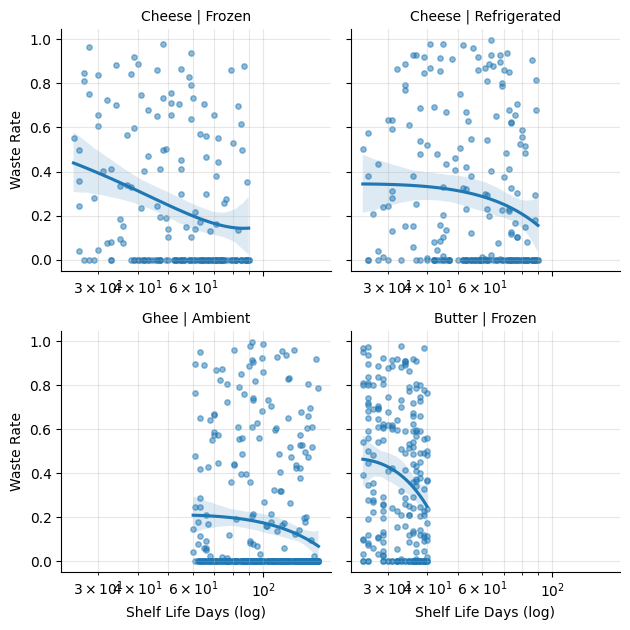

In [107]:
# 상관이 상대적으로 큰 상위 4개 세그먼트 선택
top4 = (res.assign(rank=res['spearman_rho'].rank(method='first'))
          .nsmallest(4, 'spearman_rho'))['seg'].tolist()

df_seg = df.copy()
df_seg['seg'] = df_seg['Product_Name'].astype(str) + ' | ' + df_seg['Storage_Condition'].astype(str)
df_seg = df_seg[df_seg['seg'].isin(top4)]

g = sns.lmplot(
    data=df_seg.dropna(subset=['Shelf_Life_Days','Waste_Rate']),
    x='Shelf_Life_Days', y='Waste_Rate', col='seg', col_wrap=2,
    height=3.2, scatter_kws={'s':15, 'alpha':0.5}, order=2 # 2차 다항선으로 추세만 확인
)
for ax in g.axes.flat:
    ax.set_xscale('log'); ax.grid(alpha=0.3, which='both')
g.set_titles('{col_name}'); g.set_axis_labels('Shelf Life Days (log)', 'Waste Rate')
plt.tight_layout(); plt.show()


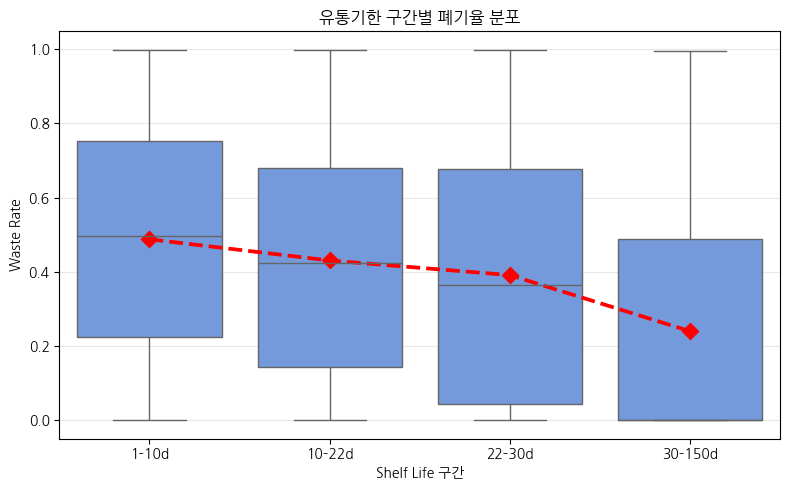

In [110]:
# 로그 기준 균등 간격 구간 생성 (보기용)
q = np.quantile(np.log1p(df1['Shelf_Life_Days']), [0, .25, .5, .75, 1])
bins = np.exp(q) - 1
labels = [f'{int(a)}–{int(b)}d' for a,b in zip(bins[:-1], bins[1:])]

d2 = df1.copy()
d2['SL_bin'] = pd.cut(d2['Shelf_Life_Days'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8,5))
sns.boxplot(data=d2, x='SL_bin', y='Waste_Rate', showfliers=False, color='cornflowerblue')
sns.pointplot(data=d2, x='SL_bin', y='Waste_Rate', estimator=np.mean, errorbar=None,
              color='red', markers='D', linestyles='--')
plt.title('유통기한 구간별 폐기율 분포', fontsize=12)
plt.xlabel('Shelf Life 구간'); plt.ylabel('Waste Rate')
plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

In [76]:
import statsmodels.formula.api as smf
# 선형
m1 = smf.ols('Waste_Rate ~ Shelf_Life_Days', data=df).fit()
print(m1.summary())

# 비선형(스플라인 3개 절점 예)
from patsy import dmatrix
import statsmodels.api as sm
X = dmatrix("bs(Shelf_Life_Days, df=5, degree=3, include_intercept=False)", df, return_type='dataframe')
m2 = sm.OLS(df['Waste_Rate'], sm.add_constant(X)).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:             Waste_Rate   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     442.3
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           1.41e-93
Time:                        09:59:23   Log-Likelihood:                -1071.4
No. Observations:                4325   AIC:                             2147.
Df Residuals:                    4323   BIC:                             2160.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4849      0.007     

In [77]:
import pandas as pd
import numpy as np

df2 = df.copy()

# 제품군별 qcut (중복 분위수 처리)
def bin_by_quantile(g, q=3):
    return pd.qcut(g['Waste_Rate'],
                   q=q, labels=[f'Q{i+1}' for i in range(q)],
                   duplicates='drop')

df2['WR_bin'] = (df2
                 .groupby('Product_Name', group_keys=False)
                 .apply(bin_by_quantile))

# (선택) 비즈니스 기준으로 절대 구간
df2['WR_bin_abs'] = pd.cut(df2['Waste_Rate'],
                            bins=[0, .10, .20, .30, 1.01],
                            labels=['<=10%','10~20%','20~30%','>30%'],
                            include_lowest=True, right=False)


ValueError: Bin labels must be one fewer than the number of bin edges

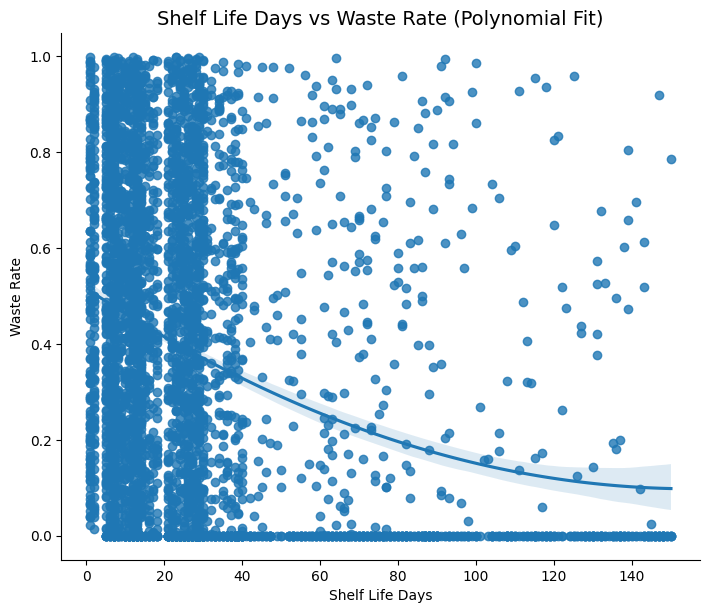

In [78]:
# 2차 다항식(곡선) 회귀선
sns.lmplot(data=df, x="Shelf_Life_Days", y="Waste_Rate", order=2, ci=95, height=6, aspect=1.2)

plt.title("Shelf Life Days vs Waste Rate (Polynomial Fit)", fontsize=14)
plt.xlabel("Shelf Life Days")
plt.ylabel("Waste Rate")
plt.show()

---
머신러닝을 위한 전처리_스케일링   
선형회귀를 위해 스케일링 실시   
   
1. 문자열 데이터 변환
- 스케일러는 대개 수치형 데이터만 처리 가능, 문자열 데이터는 수치형으로 전환해주어야 함.
- 문자열을 숫자로 변환, 순서형일 경우 Label Encoding, 범주 구분용일 경우 One-Hot encoding

In [79]:
df.describe()

,Total_Land_Area,Number_of_Cows,Date,Product_ID,Quantity,Price_per_Unit,Total_Value,Shelf_Life,Production_Date,Expiration_Date,...,Approx_Total_Revenue,Quantity_in_Stock,Minimum_Stock_Threshold,Reorder_Quantity,Sales_Period_Days,Avg_Daily_Sales,Remaining_Shelf_Life,Expected_Waste_Qty,Waste_Rate,Shelf_Life_Days
count,4325.000000,4325.000000,4325,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325,4325,...,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000
mean,503.483073,54.963699,2020-12-15 22:59:04.231213824,5.509595,500.652657,54.785938,27357.845411,29.127630,2020-11-15 08:53:22.959537664,2020-12-14 11:57:10.196531968,...,13580.265401,252.068671,55.826143,109.107820,30.587283,19.906551,-1.459653,197.045124,0.389463,29.127630
min,10.170000,10.000000,2019-01-01 00:00:00,1.000000,1.170000,10.030000,42.516500,1.000000,2018-11-02 00:00:00,2018-11-14 00:00:00,...,12.540000,0.000000,10.020000,20.020000,1.000000,0.016667,-59.000000,0.000000,0.000000,1.000000
25%,252.950000,32.000000,2019-12-20 00:00:00,3.000000,254.170000,32.460000,9946.814500,10.000000,2019-11-23 00:00:00,2019-12-20 00:00:00,...,2916.650000,66.000000,32.910000,64.280000,16.000000,2.409091,-25.000000,8.000000,0.048181,10.000000
50%,509.170000,55.000000,2020-12-02 00:00:00,6.000000,497.550000,54.400000,21869.652900,22.000000,2020-10-29 00:00:00,2020-11-29 00:00:00,...,8394.540000,191.000000,56.460000,108.340000,31.000000,6.894737,-7.000000,111.000000,0.363240,22.000000
75%,751.250000,77.000000,2021-12-15 00:00:00,8.000000,749.780000,77.460000,40954.441000,30.000000,2021-11-16 00:00:00,2021-12-13 00:00:00,...,19504.550000,387.000000,79.010000,153.390000,46.000000,16.263158,12.000000,319.000000,0.671630,30.000000
max,999.530000,100.000000,2022-12-28 00:00:00,10.000000,999.930000,99.990000,99036.369600,150.000000,2022-12-22 00:00:00,2023-05-17 00:00:00,...,89108.900000,976.000000,99.990000,199.950000,60.000000,854.000000,147.000000,976.000000,0.998004,150.000000
std,285.935061,26.111487,NaN,2.842979,288.975915,26.002815,21621.051594,30.272114,NaN,NaN,...,14617.009122,223.620870,26.301450,51.501035,17.380531,52.955060,35.039848,222.797694,0.325501,30.272114


In [80]:
df.columns

Index(['Location', 'Total_Land_Area', 'Number_of_Cows', 'Date', 'Product_ID',
       'Product_Name', 'Brand', 'Quantity', 'Price_per_Unit', 'Total_Value',
       'Shelf_Life', 'Storage_Condition', 'Production_Date', 'Expiration_Date',
       'Quantity_Sold', 'Price_per_Unit_Sold', 'Approx_Total_Revenue',
       'Customer_Location', 'Sales_Channel', 'Quantity_in_Stock',
       'Minimum_Stock_Threshold', 'Reorder_Quantity', 'Sales_Period_Days',
       'Avg_Daily_Sales', 'Remaining_Shelf_Life', 'Expected_Waste_Qty',
       'Waste_Rate', 'Shelf_Life_Days'],
      dtype='object')

In [81]:
df.select_dtypes(include=['object', 'category']).columns

Index(['Location', 'Product_Name', 'Brand', 'Storage_Condition',
       'Customer_Location', 'Sales_Channel'],
      dtype='object')

In [82]:
df_encoded = pd.get_dummies(df, columns=['Location', 'Product_Name', 'Brand', 'Storage_Condition',
       'Customer_Location', 'Sales_Channel'], drop_first=True)

In [83]:
df = pd.get_dummies(df, columns=['Location', 'Product_Name', 'Brand', 'Storage_Condition',
       'Customer_Location', 'Sales_Channel'], drop_first=True)

In [84]:
# 날짜를 수치형으로
df["Date"] = df["Date"].astype("int64") // 10**9   # 초 단위
df["Production_Date"] = df["Production_Date"].astype("int64") // 10**9
df["Expiration_Date"] = df["Expiration_Date"].astype("int64") // 10**9

In [85]:
print(df.dtypes)

Total_Land_Area                    float64
Number_of_Cows                       int64
Date                                 int64
Product_ID                           int64
Quantity                           float64
                                    ...   
Customer_Location_Telangana           bool
Customer_Location_Uttar Pradesh       bool
Customer_Location_West Bengal         bool
Sales_Channel_Retail                  bool
Sales_Channel_Wholesale               bool
Length: 75, dtype: object


In [86]:
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

In [87]:
is_numeric = np.issubdtype(df.dtypes.values[0], np.number)  # 첫 칼럼 확인
all_numeric = np.all([np.issubdtype(dtype, np.number) for dtype in df.dtypes])
print("모든 칼럼이 수치형인가?", all_numeric)

모든 칼럼이 수치형인가? True


In [88]:
df = df.drop(['Location_Chandigarh', 'Location_Delhi',
       'Location_Gujarat', 'Location_Haryana', 'Location_Jharkhand',
       'Location_Karnataka', 'Location_Kerala', 'Location_Madhya Pradesh',
       'Location_Maharashtra', 'Location_Rajasthan', 'Location_Tamil Nadu',
       'Location_Telangana', 'Location_Uttar Pradesh', 'Location_West Bengal',
       'Product_Name_Buttermilk', 'Product_Name_Cheese', 'Product_Name_Curd',
       'Product_Name_Ghee', 'Product_Name_Ice Cream', 'Product_Name_Lassi',
       'Product_Name_Milk', 'Product_Name_Paneer', 'Product_Name_Yogurt',
       'Brand_Britannia Industries', 'Brand_Dodla Dairy',
       'Brand_Dynamix Dairies', 'Brand_Mother Dairy', 'Brand_Palle2patnam',
       'Brand_Parag Milk Foods', 'Brand_Passion Cheese', 'Brand_Raj',
       'Brand_Sudha', 'Brand_Warana', 'Storage_Condition_Frozen',
       'Storage_Condition_Polythene Packet', 'Storage_Condition_Refrigerated',
       'Storage_Condition_Tetra Pack', 'Customer_Location_Chandigarh',
       'Customer_Location_Delhi', 'Customer_Location_Gujarat',
       'Customer_Location_Haryana', 'Customer_Location_Jharkhand',
       'Customer_Location_Karnataka', 'Customer_Location_Kerala',
       'Customer_Location_Madhya Pradesh', 'Customer_Location_Maharashtra',
       'Customer_Location_Rajasthan', 'Customer_Location_Tamil Nadu',
       'Customer_Location_Telangana', 'Customer_Location_Uttar Pradesh',
       'Customer_Location_West Bengal', 'Sales_Channel_Retail',
       'Sales_Channel_Wholesale'], axis= 1)

In [89]:
df.columns

Index(['Total_Land_Area', 'Number_of_Cows', 'Date', 'Product_ID', 'Quantity',
       'Price_per_Unit', 'Total_Value', 'Shelf_Life', 'Production_Date',
       'Expiration_Date', 'Quantity_Sold', 'Price_per_Unit_Sold',
       'Approx_Total_Revenue', 'Quantity_in_Stock', 'Minimum_Stock_Threshold',
       'Reorder_Quantity', 'Sales_Period_Days', 'Avg_Daily_Sales',
       'Remaining_Shelf_Life', 'Expected_Waste_Qty', 'Waste_Rate',
       'Shelf_Life_Days'],
      dtype='object')

In [90]:
from sklearn.model_selection import train_test_split

X = df.drop([ 'Product_ID','Waste_Class', 'Waste_Rate','Expected_Waste_Qty', 'Quantity_in_Stock', 'Quantity_Sold', 'Total_Value',
             'Shelf_Life_Days', 'Remaining_Shelf_Life', 'Avg_Daily_Sales', 'Sales_Period_Days',
             'Date', 'Minimum_Stock_Threshold', 'Reorder_Quantity', 'Total_Land_Area', 'Approx_Total_Revenue',
             'Price_per_Unit_Sold'], axis=1)  # 독립변수
y = df["Waste_Rate"]               # 종속변수

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KeyError: "['Waste_Class'] not found in axis"

In [ ]:
X.columns

In [91]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_validate(rf, X_train, y_train, cv=5, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,           # 깊이 제한
    min_samples_split=10,   # 노드 분할 최소 샘플 수
    min_samples_leaf=5,     # 리프 최소 샘플 수
    max_features="sqrt",    # 각 split에서 사용할 변수 개수
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("Train R²:", rf.score(X_train, y_train))
print("Test  R²:", rf.score(X_test, y_test))

데이터 특성 자체

폐기율은 단순히 "유통기한"이나 "생산량" 같은 기본 변수만으로 설명되지 않음.

판매량, 날씨, 지역 이벤트, 유통망 지연 등 외부 요인이 큼 → 설명변수 부족.

데이터 분포

대부분 낮은 폐기율에 몰려 있고, 특정 구간만 극단적으로 높음 → 모델이 평균치만 따라가 버림.

결과적으로 RMSE는 낮아도 R²는 낮게 나올 수 있음.

데이터 누수 방지 때문에 X가 제한적

미래값(실제 판매량, 폐기량)을 못 쓰고, 생산 시점 변수만 쓰면 정보량이 제한됨.

현실적으로 완벽한 예측보다는 “대략적인 위험 구간” 분류가 더 현실적일 때가 많음.

변수 중요도 확인 후 불필요한 변수 제거   
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(20))

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(20))

In [92]:
!pip install xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [93]:
# =========================
# 0) 공통 준비
# =========================
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (옵션) bool -> int 변환
for col in X_train.select_dtypes(include='bool').columns:
    X_train[col] = X_train[col].astype(int)
    X_test[col]  = X_test[col].astype(int)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
RANDOM_STATE = 42

# =========================
# 1) 모델 정의
# =========================
models = {}

# 1) RandomForest
from sklearn.ensemble import RandomForestRegressor
models["RandomForest"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features="sqrt",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

# 2) XGBoost (설치되어 있으면 추가)
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            tree_method="hist"
        ))
    ])
except Exception as e:
    print(f"[정보] XGBoost 건너뜀: {e}")

# 3) LightGBM (설치되어 있으면 추가)
try:
    from lightgbm import LGBMRegressor, early_stopping, log_evaluation
    models["LightGBM"] = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMRegressor(
            n_estimators=3000,
            learning_rate=0.03,
            max_depth=-1,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=-1  # <- fit(verbose=...) 대신 파라미터로 조정
        ))
    ])
except Exception as e:
    print(f"[정보] LightGBM 건너뜀: {e}")

# 4) CatBoost (설치되어 있으면 추가)
try:
    from catboost import CatBoostRegressor
    models["CatBoost"] = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", CatBoostRegressor(
            iterations=3000,
            learning_rate=0.03,
            depth=8,
            l2_leaf_reg=3.0,
            random_state=RANDOM_STATE,
            loss_function="RMSE",
            verbose=False  # fit에서 verbose 안 씁니다(조용히)
        ))
    ])
except Exception as e:
    print(f"[정보] CatBoost 건너뜀: {e}")

# =========================
# 2) 평가 함수 (CV + Test + 중요도)
# =========================
def evaluate_model(name, pipe, X_train, y_train, X_test, y_test):
    print(f"\n===== {name} =====")

    # 2-1) KFold 교차검증 (R2/RMSE/MAE)
    scores = cross_validate(
        pipe, X_train, y_train, cv=cv, n_jobs=-1,
        scoring=["r2", "neg_mean_squared_error", "neg_mean_absolute_error"],
        return_train_score=False
    )
    r2_mean, r2_std = scores["test_r2"].mean(), scores["test_r2"].std()
    rmse_arr = np.sqrt(-scores["test_neg_mean_squared_error"])
    mae_arr  = -scores["test_neg_mean_absolute_error"]
    print(f"[CV]   R²   : {r2_mean:.4f} ± {r2_std:.4f}")
    print(f"[CV]   RMSE : {rmse_arr.mean():.4f} (± {rmse_arr.std():.4f})")
    print(f"[CV]   MAE  : {mae_arr.mean():.4f} (± {mae_arr.std():.4f})")

    # 2-2) 홀드아웃 테스트 (부스팅류는 early stopping 적용)
    pipe_fit = pipe
    last_step = pipe.steps[-1][1]
    model_type = str(type(last_step)).lower()

    if any(kw in model_type for kw in ["xgbregressor", "lgbmregressor", "catboostregressor"]):
        # 파이프라인 분리: imputer로 변환 후 모델 단독 학습
        imputer = pipe.named_steps["imputer"]
        Xtr = imputer.fit_transform(X_train)
        Xte = imputer.transform(X_test)

        model = last_step
        # XGBoost
        if "xgbregressor" in model_type:
            model.set_params(early_stopping_rounds=100)
            model.fit(Xtr, y_train, eval_set=[(Xte, y_test)], verbose=False)
        # LightGBM (callbacks 사용, verbose 인자 사용 안 함)
        elif "lgbmregressor" in model_type:
            model.set_params(early_stopping_rounds=100)
            model.fit(
                Xtr, y_train,
                eval_set=[(Xte, y_test)],
                callbacks=[
                    early_stopping(stopping_rounds=100),
                    log_evaluation(period=0)  # 로그 억제
                ]
            )
        # CatBoost
        elif "catboostregressor" in model_type:
            model.set_params(early_stopping_rounds=100)
            model.fit(Xtr, y_train, eval_set=(Xte, y_test), verbose=False)

        pred = model.predict(Xte)
        fitted = (imputer, model)
    else:
        # RandomForest 등
        pipe_fit.fit(X_train, y_train)
        pred = pipe_fit.predict(X_test)
        fitted = pipe_fit

    # 2-3) 테스트 성능
    mse  = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, pred)
    r2   = r2_score(y_test, pred)
    print(f"[TEST] R²   : {r2:.4f}")
    print(f"[TEST] RMSE : {rmse:.4f}")
    print(f"[TEST] MAE  : {mae:.4f}")

    # 2-4) 피처 중요도 (가능할 때만)
    try:
        feature_names = X_train.columns
        if isinstance(fitted, tuple):  # (imputer, model)
            _, model = fitted
            if hasattr(model, "feature_importances_"):
                importances = pd.Series(model.feature_importances_, index=feature_names)
            else:
                importances = None
        else:  # Pipeline
            model = fitted.named_steps["model"]
            importances = pd.Series(model.feature_importances_, index=feature_names) \
                          if hasattr(model, "feature_importances_") else None

        if importances is not None:
            top = importances.sort_values(ascending=False).head(15).round(4)
            print("\n[Top-15 Feature Importances]")
            print(top)
    except Exception as e:
        print(f"(중요도 출력 생략: {e})")

# =========================
# 3) 실행
# =========================
for name, pipe in models.items():
    evaluate_model(name, pipe, X_train, y_train, X_test, y_test)


NameError: name 'X_train' is not defined

최우수 모델: CatBoost

CV: R² 0.722 ± 0.013, RMSE 0.172, MAE 0.114   

Test: R² 0.769, RMSE 0.154, MAE 0.111   
→ 전반적으로 오차가 가장 작고 일반화 성능이 최고입니다.   
   
차선책: RandomForest   

CV: R² 0.705, RMSE 0.177, MAE 0.136   

Test: R² 0.724, RMSE 0.169, MAE 0.131   
→ 안정적이지만 CatBoost보다 오차가 더 큼.   

XGBoost는 RF와 비슷하거나 약간 열세, LightGBM은 현재 설정에선 열위입니다.   

---

##1) 일반화 성능 (CV ↔ Test)

CatBoost: CV와 Test가 근접(0.722 → 0.769)하고 Test가 더 좋음    
→ 현재 분할에서 과소적합 없이 일반화 양호.   
   
RandomForest/XGBoost: CV와 Test가 대체로 일관적 → 안정적.   
   
LightGBM: CV 0.575 → Test 0.631로 갭이 크고 전반적으로 낮음.   
   
원인 가능성: (a) 파라미터가 데이터 특성에 비적합, (b) 변수가 적고 상호작용을 덜 잡음, (c) fit 시 경고(특징명 불일치)로 인한 미묘한 영향.   

##2) 오차 규모   
CatBoost Test RMSE ≈ 0.154, MAE ≈ 0.111   
→ RandomForest 대비 RMSE ~9% 감소, MAE ~15% 감소 수준(대략).   
→ 실무 관점에서 의미 있는 개선.

## 3) 피쳐 중요도 공통점

세 모델 공통 상위: Approx_Total_Revenue > Total_Value > Shelf_Life   

→ 목표변수(Waste_Rate)에 매출/가치 관련 지표가 강하게 연결되어 있음을 시사.   

→ 단, 이것이 데이터 누수(leakage) 는 아닌지 반드시 점검 필요:
   
Waste_Rate가 폐기량/생산(or 재고) 방식이라면 매출/가치 변수와 직접산식 중복은 아닐 수 있으나,
   
매출이 판매량·재고회전·수요 강도의 강력한 proxy라면, Waste_Rate 예측에 매우 유리하게 작용(과도한 상관)할 수 있습니다.   
→ 권장: 매출·가치 계열 변수를 제거/축소한 소거 실험(ablations) 으로 실제 기여도/누수 가능성 확인.

참고: LightGBM 중요도 값이 12822, 10359처럼 정규화되지 않은 카운트형(분할기여 count) 으로 보이는 건 정상입니다. 모델마다 척도가 달라 절대값 비교가 아닌 순위만 보세요.

In [ ]:
df.columns

In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve, classification_report, confusion_matrix


# 0) 라벨링 (예: 15% 이상 고위험)
df2 = df.sort_values("Production_Date")  # 실제 생산일 컬럼명으로 정렬
y_cls = (df["Waste_Rate"] >= 0.20).astype(int)

features = ['Total_Land_Area', 'Number_of_Cows', 'Date', 'Production_Date', 'Brand', 'Quantity', 'Price_per_Unit',
            'Product_Name', 'Shelf_Life', 'Storage_Condition', 'Location']  # 필요에 따라 조정
X = df[features].copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

# 모델들
from sklearn.ensemble import RandomForestClassifier
try:
    from catboost import CatBoostClassifier
    use_cat = True
except:
    use_cat = False

try:
    from xgboost import XGBClassifier
    use_xgb = True
except:
    use_xgb = False

models = {
    "RF": RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_split=5, min_samples_leaf=2,
        class_weight="balanced", n_jobs=-1, random_state=42
    )
}
if use_cat:
    models["CatBoost"] = CatBoostClassifier(
        iterations=2000, learning_rate=0.05, depth=8, l2_leaf_reg=3,
        loss_function="Logloss", eval_metric="AUC", random_seed=42,
        verbose=False, auto_class_weights="Balanced"
    )
if use_xgb:
    models["XGB"] = XGBClassifier(
        n_estimators=1500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="auc", n_jobs=-1, random_state=42
        # 불균형일 때: scale_pos_weight = (neg/pos)
    )

def evaluate_temporal(model_name, model, X, y):
    print(f"\n===== {model_name} =====")
    pipe = Pipeline([("pre", pre), ("clf", model)])
    # 시간 분할(예: 5등분)
    tscv = TimeSeriesSplit(n_splits=5)
    aucs, pr_aucs = [], []
    for fold, (tr, te) in enumerate(tscv.split(X), 1):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        proba = pipe.predict_proba(X.iloc[te])[:,1]
        aucs.append(roc_auc_score(y.iloc[te], proba))
        pr_aucs.append(average_precision_score(y.iloc[te], proba))
    print(f"[CV] ROC-AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"[CV] PR-AUC : {np.mean(pr_aucs):.3f} ± {np.std(pr_aucs):.3f}")

    # 최종 홀드아웃(가장 최신 20%를 테스트로)
    n = len(X)
    split = int(n*0.8)
    pipe.fit(X.iloc[:split], y.iloc[:split])
    y_proba = pipe.predict_proba(X.iloc[split:])[:,1]
    y_true  = y.iloc[split:]

    # 비용가중 임계값(예: FN 비용=5, FP 비용=1)
    fn_cost, fp_cost = 5.0, 1.0
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    costs = []
    for th in np.linspace(0.05, 0.95, 19):
        y_hat = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = fn_cost*fn + fp_cost*fp
        costs.append((th, cost))
    best_th, _ = min(costs, key=lambda x: x[1])

    y_pred = (y_proba >= best_th).astype(int)
    print(f"[TEST] ROC-AUC: {roc_auc_score(y_true, y_proba):.3f} | PR-AUC: {average_precision_score(y_true, y_proba):.3f}")
    print(f"[TEST] Best threshold by cost: {best_th:.2f}")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion matrix (TN FP; FN TP):")
    print(confusion_matrix(y_true, y_pred))

for name, model in models.items():
    evaluate_temporal(name, model, X, y_cls)


In [ ]:
X.select_dtypes(include=['object']).columns

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

cat_cols = ["Brand","Product_Name","Storage_Condition","Location"]
num_cols = ["Shelf_Life","Sales_Period_Days","Prod_per_Acre"]

pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=int))
    ]), cat_cols),
])

clf = Pipeline([("pre", pre), ("model", LogisticRegression(max_iter=200, class_weight="balanced"))])
clf.fit(X_train, y_train)

In [ ]:
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(np.int8)   # 또는 'int64'

In [ ]:
df_encoded = pd.get_dummies(df, columns=['Location', 'Product_Name', 'Brand', 'Storage_Condition',
       'Customer_Location', 'Sales_Channel'], drop_first=True)

In [ ]:
df_encoded

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Storage_Condition_encoded'] = le.fit_transform(df['Storage_Condition'])

df_X = df[['Quantity', 'Price_per_Unit', 'Shelf_Life', 'Storage_Condition_encoded']]

In [ ]:
y_bin = (df['Waste_Rate'] >= 0.20).astype(int)

df_X = df_encoded[['Quantity','Price_per_Unit','Shelf_Life'] +
                  [c for c in df_encoded.columns if c.startswith('Storage_Condition_')]]

X_train, X_test, y_train, y_test = train_test_split(df_X, y_bin, test_size=0.2, random_state=42)

ss = StandardScaler()
X_train_s = ss.fit_transform(X_train)
X_test_s  = ss.transform(X_test)

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

clf = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
clf.fit(X_train_s, y_train)

print("Train acc:", clf.score(X_train_s, y_train))
print("Test  acc:", clf.score(X_test_s, y_test))
print("Test AUC:", roc_auc_score(y_test, clf.predict_proba(X_test_s)[:,1]))

In [ ]:
import pandas as pd
import numpy as np

# 구간 정의 (0~40%까지 4등급, 나머지는 -1로 표시)
bins = [0, 0.10, 0.20, 0.30, 0.40]
labels = [0, 1, 2, 3]

df['Waste_Class'] = pd.cut(df['Waste_Rate'], bins=bins, labels=labels, include_lowest=True).astype(float)

In [ ]:
bins   = [0, 0.10, 0.20, 0.30, 0.40, 1.01]  # 1.0까지 커버(+ε)
labels = [0, 1, 2, 3, 4]                    # 5등급
y = pd.cut(df['Waste_Rate'], bins=bins, labels=labels,
           include_lowest=True, right=False).astype(int)

In [ ]:
feature_cols = ['Quantity','Price_per_Unit','Shelf_Life'] + \
               [c for c in df_encoded.columns if c.startswith('Storage_Condition_')]

X = df_encoded[feature_cols]
y = df['Waste_Class']   # 다중 분류 타깃

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ss = StandardScaler()
X_train_s = ss.fit_transform(X_train)
X_test_s  = ss.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)

print("Accuracy:", clf.score(X_test_s, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

실제 클래스 0 → 105개만 맞춤, 225개는 잘못 예측해서 클래스 1로 분류

실제 클래스 1 → 493개 맞춤, 42개만 잘못 예측해서 클래스 0으로 분류

→ 모델이 클래스 1 쪽으로 강하게 편향되어 있음. (Recall 0.92 vs Recall 0.32)

전반 정확도(69%)는 그럭저럭 보이지만, 클래스 불균형이 심각함.

모델이 "클래스 1(10~20%)"을 주로 예측하면서 Recall은 높고, 클래스 0은 거의 잡지 못함.

즉, 특정 구간 예측(0~10%)에는 실패하고, 10~20% 구간 중심으로 예측하는 모델이 됨.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("RF Accuracy:", rf.score(X_test, y_test))

In [ ]:
df.columns

In [ ]:
# 생산 시점에 알 수 있는 변수만 선택
use_cols = ['Date','Product_Name', 'Brand', 'Quantity',
             'Price_per_Unit', 'Shelf_Life', 'Storage_Condition', 'Production_Date','Expiration_Date']

X_raw = df[use_cols]
y = df["Waste_Rate"]   # 연속값 (회귀) or 구간화 (분류)

In [ ]:
X = pd.get_dummies(X_raw, drop_first=True)   # 원-핫 인코딩

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score

print("R²:", r2_score(y_test, pred))
print("MAE:", mean_absolute_error(y_test, pred))

In [ ]:
# 구간화 (예: 0~10%, 10~20%, 20~30%, 30~40%)
bins = [0, 0.10, 0.20, 0.30, 0.40, 1.01]
labels = [0,1,2,3,4]   # 5등급
y_class = pd.cut(y, bins=bins, labels=labels, include_lowest=True).astype(int)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_cls = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_cls.fit(X_train, y_class.loc[y_class.index.isin(X_train.index)])

y_pred = rf_cls.predict(X_test)
print(classification_report(y_class.loc[X_test.index], y_pred))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_class.loc[y_class.index.isin(X_train.index)])
print(dt.score(X_train, y_class))
print(dt.score(X_test, y_class))

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ----------------------------------
# 1) 데이터 준비
# ----------------------------------
# (예시) 생산 시점에 알 수 있는 변수만 사용
use_cols = [
    "Brand", "Product_Name", "Storage_Condition",
    "Shelf_Life", "Production_Date", "Location",
    "Quantity", "Price_per_Unit"
]
X_raw = df[use_cols].copy()
y_raw = df["Waste_Rate"].copy()

# ----------------------------------
# 2) 파생변수 추가 (Feature Engineering)
# ----------------------------------
# 날짜 기반 변수
X_raw["Production_Date"] = pd.to_datetime(X_raw["Production_Date"], errors="coerce")
X_raw["prod_month"] = X_raw["Production_Date"].dt.month
X_raw["prod_dayofweek"] = X_raw["Production_Date"].dt.dayofweek
X_raw.drop(columns=["Production_Date"], inplace=True)

# 상호작용 변수
X_raw["qty_per_shelf"] = X_raw["Quantity"] / (X_raw["Shelf_Life"] + 1)

# ----------------------------------
# 3) 범주형 인코딩
# ----------------------------------
X = pd.get_dummies(X_raw, drop_first=True)

# ----------------------------------
# 4) train/test 분리
# ----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.2, random_state=42
)

# 로그 변환 버전 (극단치 완화)
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# ----------------------------------
# 5) 모델 정의
# ----------------------------------
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
}

# ----------------------------------
# 6) 평가 함수
# ----------------------------------
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 버전 안전한 RMSE 계산기
def RMSE(y_true, y_pred):
    try:
        # 신버전이면 이 경로(있다면)
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # 구버전 호환: sqrt(MSE)
        return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(name, model, X_train, X_test, y_train, y_test, log=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # 로그 타깃 사용 시 역변환
    if log:
        pred = np.expm1(pred)
        y_test = np.expm1(y_test)

    r2   = r2_score(y_test, pred)
    rmse = RMSE(y_test, pred)          # ← 여기만 변경
    mae  = mean_absolute_error(y_test, pred)

    print(f"=== {name} (log={log}) ===")
    print(f"R²   : {r2:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print("-"*40)

# ----------------------------------
# 7) 실행
# ----------------------------------
for name, model in models.items():
    # 원본 y
    evaluate_model(name, model, X_train, X_test, y_train, y_test, log=False)
    # 로그 변환 y
    evaluate_model(name, model, X_train, X_test, y_train_log, y_test_log, log=True)

# ----------------------------------
# 8) 중요 피처 확인 (예: 랜덤포레스트)
# ----------------------------------
rf = models["RandomForest"].fit(X_train, y_train)
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n[상위 10개 중요 변수]")
print(feat_imp.head(10))

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 1) 사용할 칼럼(생산 시점에 확정되는 것만)
use_cols = [
    "Brand","Product_Name","Storage_Condition",
    "Shelf_Life","Production_Date","Location",
    "Quantity","Price_per_Unit"
]
X_raw = df[use_cols].copy()

# 2) 파생변수 (미래 정보 사용 금지)
X_raw["Production_Date"] = pd.to_datetime(X_raw["Production_Date"], errors="coerce")
X_raw["month"] = X_raw["Production_Date"].dt.month
X_raw["dow"] = X_raw["Production_Date"].dt.dayofweek
X_raw["is_weekend"] = (X_raw["dow"] >= 5).astype(int)
X_raw.drop(columns=["Production_Date"], inplace=True)

X_raw["qty_per_shelf"] = X_raw["Quantity"] / (X_raw["Shelf_Life"] + 1)

# 3) 인코딩(원-핫) + 스케일링
X_numcat = pd.get_dummies(X_raw, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numcat)

# 4) (선택) PCA로 노이즈/차원 축소
pca = PCA(n_components=0.9, svd_solver="full")  # 누적분산 90% 유지
X_pca = pca.fit_transform(X_scaled)

# 5) k 탐색 (엘보우+실루엣)
results = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    db  = davies_bouldin_score(X_pca, labels)
    results.append((k, sil, db))
best_k = max(results, key=lambda t: t[1])[0]
print("k 탐색(실루엣 최대):", results, "=> best_k:", best_k)

# 6) 최종 모델 적합
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# 7) 해석용 결합(타깃은 학습에 미사용) → 사후 프로파일링
out = df.copy()
out["cluster"] = clusters

# 군집별 프로파일(입력 특성)
profile_inputs = (out
  .groupby("cluster")
  .agg({
      "Shelf_Life": ["mean","median"],
      "Quantity": ["mean","median"],
      "Price_per_Unit": ["mean","median"],
      "Brand": lambda s: s.value_counts().index[0],           # 최빈
      "Product_Name": lambda s: s.value_counts().index[0],
      "Storage_Condition": lambda s: s.value_counts().index[0],
      "Location": lambda s: s.value_counts().index[0]
  })
)
print(profile_inputs)

# (선택) 군집별 폐기율(타깃) 분포 비교: 학습엔 미사용, 해석만
if "Waste_Rate" in out.columns:
    wr_summary = out.groupby("cluster")["Waste_Rate"].describe().round(3)
    print("\n[군집별 Waste_Rate 요약]\n", wr_summary)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# -------------------------------
# 0) 설정
# -------------------------------
USE_COLS = [
    "Brand","Product_Name","Storage_Condition",
    "Shelf_Life","Production_Date","Location",
    "Quantity","Price_per_Unit"
]
TOP_K_CAT = 5               # 범주형 Top-k 막대그래프
K_RANGE   = range(2, 11)    # k 탐색 범위

# -------------------------------
# 1) 전처리 (누수 방지)
# -------------------------------
X_raw = df[USE_COLS].copy()

# 날짜 파생 (생산 시점 정보만)
X_raw["Production_Date"] = pd.to_datetime(X_raw["Production_Date"], errors="coerce")
X_raw["month"] = X_raw["Production_Date"].dt.month
X_raw["dow"] = X_raw["Production_Date"].dt.dayofweek
X_raw["is_weekend"] = (X_raw["dow"] >= 5).astype(int)
X_raw.drop(columns=["Production_Date"], inplace=True)

# 상호작용/밀도 지표
X_raw["qty_per_shelf"] = X_raw["Quantity"] / (X_raw["Shelf_Life"] + 1)

# 원-핫 인코딩
X = pd.get_dummies(X_raw, drop_first=True)

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 2) PCA 변환 (시각화/노이즈 완화)
# -------------------------------
pca = PCA(n_components=0.9, svd_solver="full")  # 누적분산 90%
X_pca = pca.fit_transform(X_scaled)

# -------------------------------
# 3) k 선택: 실루엣 최고값
# -------------------------------
sil_results = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_results.append((k, sil))
best_k, best_sil = max(sil_results, key=lambda t: t[1])
print("[k 탐색 결과] (k, silhouette):", sil_results)
print(f"[선택된 k] {best_k} (silhouette={best_sil:.3f})")

# 최종 적합
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
labels = kmeans.fit_predict(X_pca)

# 원본 DF에 군집 부착 (사후 해석용; 학습에는 미사용)
out = df.copy()
out["cluster"] = labels

# -------------------------------
# 4) 시각화
# -------------------------------

# (A) PCA 2D 산점도 (클러스터)
plt.figure(figsize=(7,6))
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=12, alpha=0.7, label=f"Cluster {c}")
plt.title("PCA 2D Scatter by Cluster (PCA 2차원 산점도)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# (B) 실루엣 다이어그램
sil_vals = silhouette_samples(X_pca, labels)
y_lower = 10
plt.figure(figsize=(7,6))
for c in range(best_k):
    c_sil = sil_vals[labels == c]
    c_sil.sort()
    y_upper = y_lower + len(c_sil)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, c_sil, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * len(c_sil), str(c))
    y_lower = y_upper + 10
plt.axvline(x=best_sil, linestyle="--")
plt.title(f"Silhouette Plot (k={best_k}, mean={best_sil:.3f})")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

# (C) 군집 × 수치 특성 평균(표준화) 히트맵
# 수치열 선택 (파생 포함)
num_cols = ["Shelf_Life","Quantity","Price_per_Unit","month","dow","is_weekend","qty_per_shelf"]
num_cols = [c for c in num_cols if c in out.columns]  # 존재 확인

prof_num = out.groupby("cluster")[num_cols].mean()
# 특성별 표준화(행간 비교를 위해 열 z-score)
prof_num_std = (prof_num - prof_num.mean(axis=0)) / (prof_num.std(axis=0) + 1e-9)

plt.figure(figsize=(1.6*len(num_cols)+3, 0.5*best_k+3))
im = plt.imshow(prof_num_std.values, aspect="auto")
plt.colorbar(im, fraction=0.025, pad=0.04)
plt.yticks(ticks=np.arange(prof_num_std.shape[0]), labels=[f"C{c}" for c in prof_num_std.index])
plt.xticks(ticks=np.arange(len(num_cols)), labels=num_cols, rotation=45, ha="right")
plt.title("Cluster × Numeric Feature (Z-scored Means)\n(군집×수치 특성 평균: 표준화)")
plt.tight_layout()
plt.show()

# (D) 군집별 범주형 Top-k 빈도 막대그래프
def plot_topk_bars(df_, cluster_col, cat_col, topk=TOP_K_CAT):
    clusters = sorted(df_[cluster_col].unique())
    for c in clusters:
        s = (df_.loc[df_[cluster_col]==c, cat_col]
             .value_counts()
             .head(topk))
        plt.figure(figsize=(6,3.5))
        plt.bar(s.index.astype(str), s.values)
        plt.title(f"Cluster {c} - Top {topk} {cat_col} (최다 빈도)")
        plt.ylabel("Count")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

for cat_col in ["Brand","Storage_Condition"]:
    if cat_col in out.columns:
        plot_topk_bars(out, "cluster", cat_col, topk=TOP_K_CAT)

# (E) (선택) 군집별 폐기율 분포 박스플롯 (학습엔 미사용, 사후 해석용)
if "Waste_Rate" in out.columns:
    plt.figure(figsize=(7,5))
    data = [out.loc[out["cluster"]==c, "Waste_Rate"].dropna().values for c in sorted(out["cluster"].unique())]
    plt.boxplot(data, labels=[f"C{c}" for c in sorted(out["cluster"].unique())], showfliers=False)
    plt.title("Waste_Rate by Cluster (사후 해석용)")
    plt.ylabel("Waste_Rate")
    plt.tight_layout()
    plt.show()

# -------------------------------
# 5) 요약 리포트(텍스트)
# -------------------------------
sizes = out["cluster"].value_counts().sort_index()
print("\n[군집 크기]"); print(sizes.to_string())

if "Waste_Rate" in out.columns:
    wr_desc = out.groupby("cluster")["Waste_Rate"].describe().round(3)
    print("\n[군집별 Waste_Rate 요약]"); print(wr_desc.to_string())


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
sil = silhouette_score(X_pca, labels)
ch  = calinski_harabasz_score(X_pca, labels)
db  = davies_bouldin_score(X_pca, labels)
print(sil, ch, db)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
import numpy as np

def cluster_once(X, k, seed):
    return KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(X)

base = cluster_once(X_pca, best_k, 42)
scores = []
for s in range(50):
    idx = np.random.choice(len(X_pca), len(X_pca), replace=True)
    lab = cluster_once(X_pca[idx], best_k, s)
    scores.append(NMI(base[idx], lab))
print("NMI 안정성 평균:", np.mean(scores))
